#TP2 - Ciencia de Datos (2C 2024)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import joblib

from sklearn.metrics import f1_score

In [ ]:
!pip install scipy
# Import necessary libraries
from scipy.stats import randint, uniform

In [ ]:
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [ ]:
import re
from bs4 import BeautifulSoup
import xgboost as xgb

In [ ]:
df=pd.read_csv("train.csv")

In [ ]:
df.shape

(7900, 5)

In [ ]:
df.head(15)

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2
5,8896,Service Registry: REST endpoints URL renaming,Endpoint URLs of Service Registry REST service...,project1,1
6,2304,TiStudio: Projects - A pane is missing when cr...,Details: If you try to create the default Tita...,project8,5
7,9192,Avoid installing test and performance services...,The membership plans are associated with organ...,project8,5
8,1888,Add Unit Tests for CC SPI infrastructure,"Test Converter, Configuration, Definition and ...",project6,3
9,4609,Agent should not return partial state when a r...,Currently when a user is hitting /state.json o...,project5,3


#Preprocesamiento

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


In [ ]:
df.describe()

,id,storypoint
count,7900.000000,7900.000000
mean,4951.059620,3.885190
std,2853.243052,3.027804
min,1.000000,1.000000
25%,2475.750000,2.000000
50%,4970.500000,3.000000
75%,7413.250000,5.000000
max,9874.000000,40.000000


In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


Como un primer acercamiento a entender el dominio del problema, podemos ver a través del conteo de casos de uso y sus storypoint que aproximadamente un 80% de los registros corresponden con la clasificación de 3, 5, 1 y 2 correspondientemente.

In [ ]:
df

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2
...,...,...,...,...,...
7895,5734,"As Patrick, I want to be able to create a new ...",# Dialog is shown # fields we need to populat...,project7,3
7896,5191,GMock warning in ReservationTest.ACLMultipleOp...,{noformat} [ RUN ] ReservationTest.ACLMu...,project5,1
7897,5390,WSDL Improvement of the SOAP based Service Loc...,As developer I want to use a service that foll...,project1,3
7898,860,Platform Config Wizard: Auto-check if Tizen is...,This is an extension of TISTUD-5246. When the ...,project8,3


In [ ]:
# en orden ascendente solamente las storypoints que aparecen
story_points = df['storypoint'].unique()
story_points.sort()
story_points

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 14, 15, 16, 20, 21, 24,
       32, 34, 40])

In [ ]:
df['title'].value_counts()

,count
title,
Fix 'cluster/containers' REST endpoint with security enabled,4
As a user I would like to be able to edit a Rapid View that I created using someone elses saved filter,2
"When unconfigured platform is selected, dynamically add install page as next page",2
As a user I would like the ability to see a horizontal swimlane on my Rapid Board,2
All Epic Progress Report,2
...,...
Get Container Name information when launching a container task,1
Ability to sort the certificates and provisioning profiles in Titanium Studio Preferences->Titanium->iOS platform,1
Add an example framework to test persistent volumes.,1


In [ ]:

(df['project'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
project,,
project6,2455,31.075949
project8,2292,29.012658
project5,1243,15.734177
project1,619,7.835443
project2,489,6.189873
project4,303,3.835443
project3,267,3.379747
project7,232,2.936709


####Análisis de la limpieza
Notar que los número que quedan por encima del 1% son todos números Fibonacci.  
Esto es porque los storypoints se suelden definir con una técnica llamada planning poker:  
El Planning póker es una técnica para estimar usando story points en donde cada miembro del Development Team debe otorgar un estimado en story points al ítem que se esté tratando, usando una sucesión de Fibonacci (0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89).  
  
  
Se utiliza en Redes Neuronales Profundas.

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


In [ ]:
df_original=df.copy()
df_original2=df.copy()
df_rn=df.copy()

### Creación de conjuntos train y test

In [ ]:
#Para poder unir los predicted con reales
df.set_index('id', inplace=True)

In [ ]:
#Se crea una nueva columna que concatene title y description para tener más información
df['text'] = df['title'] + ' ' + df['description']

In [ ]:
df.loc[6183].tolist()

['Test Migration of Entity Versions',
 'Test migration from v2 to v3 for the upcoming release',
 'project3',
 3,
 'Test Migration of Entity Versions Test migration from v2 to v3 for the upcoming release']

####revisar
este era el de antes, pero me dio algunos fallos. probar de nuevo

In [ ]:
#Se eliminan los registros que tiene sólo 1 registro tal que sino no funcionan los modelos
df = df.drop(df[df['storypoint'].isin([32,34,14,24])].index)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X = df[['description', 'title', 'text']]
y = df['storypoint']

# División de datos conservando ambas columnas y manteniendo el índice alineado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=1310)

# Asegurarnos de que las divisiones de title y description se hagan a partir de X_train y X_test alineados
X_train_title = X_train['title']
X_test_title = X_test['title']

X_train_description = X_train['description']
X_test_description = X_test['description']

X_train_text = X_train['text']
X_test_text = X_test['text']

# Confirmar que ambos conjuntos de prueba tienen el mismo tamaño
print("Tamaño de X_test_title:", len(X_test_title))
print("Tamaño de X_test_text:", len(X_test_text))
print("Tamaño de X_train_description:", len(X_test_description))



Tamaño de X_test_title: 1580
Tamaño de X_test_text: 1580
Tamaño de X_train_description: 1580


In [ ]:
X_train_title, X_test_title=X_train.title, X_test.title
X_train_text, X_test_text=X_train.description.copy(), X_test.description.copy()
X_train_descrption, X_test_description=X_train.description, X_test.description
y_train_orginal=y_train.copy()
y_train_original=y_train_orginal.copy()

##nota para el uso de los train:
El que mejor anda siempre es description


*   X_train_title        ->y_train_original
*   X_train_description   ->y_train_original
*   X_train_text:        -> y_train //Es una concatenación de title y description (no estaba funcando, ahora ya creé la columna con la concatenación)



In [ ]:
y_train.value_counts()

,count
storypoint,
3,1478
5,1354
1,1303
2,1021
8,820
4,133
13,123
10,25
20,25


In [ ]:
X.loc[2469]

,2469
description,- Smaller one than in the general one - Hover...
title,MVR: Sprint Report to include a burndown for t...


In [ ]:
X_train_text.tolist()[:7]

['No provisioning profiles shown in run-on-iOS-device launch configuration When manually creating a launch configuration for profiling on iOS device, I saw the provisioning profiles combo box is empty, and the same applies to running on iOS device as well. The iOS preference page does show the list correctly.  ',
 'Refactor the tests so that contexts are destroyed properly  In our tests the context is destroyed at the end of each module.  It should be destroyed at the close of the container.',
 "Enable running tests without authorizer. We do not support creating {{Master}} instance without an {{Authorizer}} in tests: https://github.com/apache/mesos/blob/aa497e81c945677c570484a8aa1a8c8b2e979dfd/src/tests/cluster.cpp#L217. This leads to a segfault when {{masterFlags.acls = None();}} is used in a test, while it's a valid use case and should be allowed.    Alternatively, we use {{masterFlags.acls = ACLs();}}, which triggers creation of {{LocalAuthorizer}} with emtpy {{ACLs}}, which seems t

#Modelos

#### Definiendo funciones
Definimos funciones:


*   clean_text: Para limpiar el texto
*   tokenizer: Para tokenizar
*   stoplist



######probar
probar comentando y descomentando otros  
En general probé y con el de lowe() bastaria, no hacen gran diferencia

In [ ]:
import re

#Le cambio el nombre a ver si con el nuevo funciona mejor
def clean_text_v1(text):
    # Convierte el texto a minúsculas
    text = text.lower()
    # Elimina caracteres especiales y números (opcional si no son útiles)
  ###PROBAR  text = re.sub(r"[^a-zA-Z\s]", '', text)

    ##extras mios
    #text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)##PROBAR USANDO Y NO, PODRIA HABER INFO EN LA URLs
    re.sub(r"\s+", " ", text)  # Reemplaza múltiples espacios por uno solo
    re.sub(r"^\s+", "", text)  # Elimina espacios al inicio
    re.sub(r"\s+$", "", text)  # Elimina espacios al final
    #re.sub(r"(.)\1{2,}", r"\1\1", text)  # Reduce "aaahhh!!!" a "aahh!!"
    #re.sub(r"\{\{.*?\}\}", "", text)  # Remueve texto entre llaves dobles
    #re.sub(r"\{noformat\}", "", text)  # Remueve {noformat}
    #re.sub(r"\{code\}.*?\{code\}", "", text, flags=re.DOTALL)  # Remueve bloques de código
    #re.sub(r"<.*?>", "", text)  # Remueve etiquetas HTML o XML
    #re.sub(r"\b\d{1,3}(?:\.\d{1,3}){3}:\d+\b", "", text)  # IP con puerto (Ej. 192.168.1.1:8080)
    #re.sub(r"\bE\d{4}\b", "", text)  # Remueve códigos de error (E0630, etc.)
    #re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)  # Remueve comentarios de bloque
    #re.sub(r"\bsegfault\b", "segmentation fault", text, flags=re.IGNORECASE)  # Cambia términos coloquiales o técnicos
    #re.sub(r"[^\w\s]", "", text)  # Remueve todo excepto letras, números y espacios
    #re.sub(r"\b\d{2}:\d{2}:\d{2}\b", "", text)  # Remueve marcas de tiempo (ej. 21:41:14)
    #re.sub(r"'[^']*'|\"[^\"]*\"", "", text)  # Remueve texto entre comillas
    #re.sub(r"\b\d{5,}\b", "0", text)  # Reemplaza números largos con un 0

    return text


In [ ]:
def clean_text(text):
    """
    Cleans the input text to retain only important words relevant for prediction.
    """
    # Remove HTML tags (if present)
    text = BeautifulSoup(text, "html.parser").get_text()

    # Replace underscores with spaces (e.g., SlaveRecoveryTest_MultipleFrameworks -> Slave Recovery Test Multiple Frameworks)
    text = re.sub(r'_', ' ', text)

    # Remove technical logs, timestamps, and IDs (e.g., "I0513", line numbers, etc.)
    text = re.sub(r'\b[Ii]\d{4,}|\d{4}-\d{2}-\d{2}|\bline\b|\d+\.\d+\.\d+', '', text)

    # Remove file paths and other unwanted patterns (like `../../src/tests/`)
    text = re.sub(r'\b\.\.\/[^\s]*', '', text)

    # Split angled brackets and colons (e.g., Test<mesos::internal>)
    text = re.sub(r'[<>]', ' ', text)  # Replace `<` and `>` with spaces
    text = re.sub(r'::', ' ', text)    # Replace `::` with spaces

    # Split camel-case or compound words into separate words
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Handle camel-case
    text = re.sub(r'([A-Z]+)([A-Z][a-z])', r'\1 \2', text)  # Handle all-caps edge cases

    # Remove stack traces and debugging details (e.g., "(gdb) bt")
    text = re.sub(r'\(gdb\).*|#\d+\s.*', '', text)

    # Remove special characters and retain alphanumeric characters and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove hexa values
    text = re.sub(r'0x[0-9a-fA-F]+', '', text)

    # Remove multiple spaces and convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()

    pattern = r'\b[a-f0-9]\b'

    # Replace words like 'eaf5d8d6'
    text = re.sub(pattern, '', text)

    # Keep keywords like task states (TASK_FAILED, TASK_KILLED) and meaningful words
    keywords = re.findall(r'\b\w{3,}\b', text)  # Words with 3 or more characters
    filtered_words = [word for word in keywords if not word.isdigit()]  # Exclude pure digits

    # Convert to lowercase and join back into a cleaned text
    return ' '.join(filtered_words).lower()

In [ ]:
df['title'] = df['title'].apply(clean_text)

In [ ]:
df['description'] = df['description'].apply(clean_text)

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stoplist = set(stopwords.words("english"))

def tokenizer(text):
    # Tokeniza el texto, elimina las palabras vacías (stopwords) y las convierte a minúsculas
    tokens = word_tokenize(text)
    return [w.lower() for w in tokens if w.isalpha() and w.lower() not in stoplist]


In [ ]:
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tokenizer(clean_text(X_train_text.iloc[0]))[:100]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['provisioning',
 'profiles',
 'shown',
 'run',
 'device',
 'launch',
 'configuration',
 'manually',
 'creating',
 'launch',
 'configuration',
 'profiling',
 'device',
 'saw',
 'provisioning',
 'profiles',
 'combo',
 'box',
 'empty',
 'applies',
 'running',
 'device',
 'well',
 'preference',
 'page',
 'show',
 'list',
 'correctly']

 Definimo un stoplist

In [ ]:
stoplist = stopwords.words("english")

In [ ]:
stoplist[:28]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's"]

In [ ]:
# tokenizo el stoplist con el mismo tokenizar que voy a usar en el corpus
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)

In [ ]:
stoplist_tokenized[:35]

['could', 'might', 'must', 'need', 'sha', 'wo', 'would']

In [ ]:
# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

#### Extracción de Features

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=7)

X_train = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario -> Acá NO fiteo sino sólo transformo para luego poder usar el modelo
X_train

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-48-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


<6316x3439 sparse matrix of type '<class 'numpy.int64'>'
	with 203826 stored elements in Compressed Sparse Row format>

In [ ]:
shape = X_train.shape
total_elements = shape[0] * shape[1]

print("Matrix shape:", shape)
print("Matrix size:", total_elements)


Matrix shape: (6316, 3439)
Matrix size: 21720724


In [ ]:
non_zero_elements = X_train.nnz  # nnz es el número de elementos distintos de cero
percentage_non_zero = (non_zero_elements / total_elements) * 100


print("Percentage of non-zero elements:", percentage_non_zero, "%")


Percentage of non-zero elements: 0.9383941345601556 %


In [ ]:
# Vocabulario
vocab = count_vect.vocabulary_

# Obtener las primeras 20 palabras del vocabulario
print(list(vocab.keys())[:50])

['provisioning', 'profiles', 'shown', 'run', 'device', 'launch', 'configuration', 'manually', 'creating', 'profiling', 'saw', 'combo', 'box', 'empty', 'applies', 'running', 'well', 'preference', 'page', 'show', 'list', 'correctly', 'refactor', 'tests', 'contexts', 'destroyed', 'properly', 'context', 'end', 'module', 'close', 'container', 'enable', 'without', 'authorizer', 'support', 'master', 'instance', 'https', 'github', 'com', 'apache', 'mesos', 'blob', 'src', 'cluster', 'cpp', 'leads', 'segfault', 'flags']


In [ ]:
count_vect.get_feature_names_out()[:200]

array(['aaa', 'ability', 'able', 'abort', 'aborted', 'abstraction',
       'accept', 'acceptance', 'accepted', 'accepts', 'access',
       'accessed', 'accessible', 'accessing', 'accidentally', 'according',
       'accordingly', 'account', 'accounts', 'achieve', 'acknowledgement',
       'acl', 'acls', 'across', 'acs', 'act', 'action', 'actions',
       'activate', 'activated', 'active', 'activemq', 'activity',
       'actual', 'actually', 'ad', 'adapt', 'adapter', 'adapters', 'add',
       'added', 'adding', 'addition', 'additional', 'additionally',
       'address', 'addressed', 'addresses', 'adds', 'adjust', 'admin',
       'administration', 'administrator', 'admins', 'admission',
       'advance', 'advanced', 'advantage', 'advertising', 'affect',
       'affected', 'affects', 'agent', 'agents', 'aggregate', 'agile',
       'ago', 'agreement', 'aka', 'alert', 'algorithm', 'alias',
       'allocate', 'allocated', 'allocation', 'allocator', 'allow',
       'allowed', 'allowing', 'allo

Definimos diciconario de métricas

In [ ]:
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_squared_error, r2_score # Import the necessary functions
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1_macro': 'f1_macro',
    'rmse': make_scorer(root_mean_squared_error),
    'mse': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)
}

## Modelo: Naive Bayes

con el train de title y descrption

In [ ]:
from sklearn.model_selection import cross_validate # Import cross_validate
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import make_scorer, root_mean_squared_error


clf = MultinomialNB(alpha=1)
scores_nb = cross_validate(clf, X_train, y_train, cv=6, scoring=scoring_metrics, return_train_score=False)
for metric, score in scores_nb.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

fit_time: 0.0616 (sd = 0.0433)
score_time: 0.0664 (sd = 0.0210)
test_accuracy: 0.2552 (sd = 0.0139)
test_precision: 0.3399 (sd = 0.0232)
test_recall: 0.2552 (sd = 0.0139)
test_f1_macro: 0.1224 (sd = 0.0144)
test_rmse: 4.3038 (sd = 0.1534)
test_mse: 18.5466 (sd = 1.3161)
test_R2: -1.0910 (sd = 0.1900)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

con el train de descrption

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_title)

clf = MultinomialNB(alpha=1)
scores_nb = cross_validate(clf, X_train_vec, y_train, cv=6, scoring=scoring_metrics, return_train_score=False)

for metric, score in scores_nb.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

fit_time: 0.0066 (sd = 0.0006)
score_time: 0.0150 (sd = 0.0012)
test_accuracy: 0.3482 (sd = 0.0127)
test_precision: 0.3780 (sd = 0.0380)
test_recall: 0.3482 (sd = 0.0127)
test_f1_macro: 0.2259 (sd = 0.0122)
test_rmse: 2.4768 (sd = 0.0398)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_text)

clf = MultinomialNB(alpha=1)
scores_nb = cross_validate(clf, X_train_vec, y_train, cv=6, scoring=scoring_metrics, return_train_score=False)

for metric, score in scores_nb.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

fit_time: 0.0118 (sd = 0.0014)
score_time: 0.0153 (sd = 0.0027)
test_accuracy: 0.3431 (sd = 0.0119)
test_precision: 0.5224 (sd = 0.0698)
test_recall: 0.3431 (sd = 0.0119)
test_f1_macro: 0.1965 (sd = 0.0108)
test_rmse: 2.4073 (sd = 0.0418)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Inflando el alpha a 9 mejora el RMSE.

In [ ]:
clf = MultinomialNB(alpha=9)
scores_nb = cross_validate(clf, X_train, y_train, cv=6, scoring=scoring_metrics, return_train_score=False)
for metric, score in scores_nb.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

fit_time: 0.0097 (sd = 0.0017)
score_time: 0.0138 (sd = 0.0020)
test_accuracy: 0.3051 (sd = 0.0146)
test_precision: 0.3152 (sd = 0.0143)
test_recall: 0.3051 (sd = 0.0146)
test_f1_macro: 0.1228 (sd = 0.0097)
test_rmse: 3.3428 (sd = 0.0762)
test_mse: 11.1800 (sd = 0.5061)
test_R2: -0.2589 (sd = 0.0702)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

###Conclusión
Este es el mejor modelo de De Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_text)

clf = MultinomialNB(alpha=1)
scores_nb = cross_validate(clf, X_train_vec, y_train, cv=6, scoring=scoring_metrics, return_train_score=False)

for metric, score in scores_nb.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

fit_time: 0.0275 (sd = 0.0003)
score_time: 0.0279 (sd = 0.0071)
test_accuracy: 0.3401 (sd = 0.0088)
test_precision: 0.4056 (sd = 0.0483)
test_recall: 0.3401 (sd = 0.0088)
test_f1_macro: 0.0946 (sd = 0.0026)
test_rmse: 2.8313 (sd = 0.0665)
test_mse: 8.0205 (sd = 0.3759)
test_R2: 0.0982 (sd = 0.0125)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Modeo: Dummy

In [ ]:
clf_dummy = DummyClassifier(strategy="stratified")
scores_dummy = cross_validate(clf_dummy, X_train, y_train, cv=6, scoring=scoring_metrics)
for metric, score in scores_dummy.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

fit_time: 0.0029 (sd = 0.0008)
score_time: 0.0140 (sd = 0.0024)
test_accuracy: 0.1976 (sd = 0.0053)
test_precision: 0.1958 (sd = 0.0054)
test_recall: 0.1976 (sd = 0.0053)
test_f1_macro: 0.0752 (sd = 0.0074)
test_rmse: 4.1378 (sd = 0.1503)
test_mse: 17.1437 (sd = 1.2133)
test_R2: -0.9271 (sd = 0.1013)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samp

Nuestro modelo entrenado performa un poco mejor que un dummy pero no tanto

## Modelo: N-gramas

###N-gramas description

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer,
                             min_df=7, stop_words=stoplist_tokenized, ngram_range=(1,2))
X_train_ngrams = count_vect.fit_transform(X_train_text)

scores_ngrams = cross_validate(clf, X_train_ngrams, y_train, cv=6, scoring=scoring_metrics)
print(">> Número de features = ",X_train_ngrams.shape[1])
print("\n__________N-gramas Model Metrics__________")
for metric, score in scores_ngrams.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  4955

__________N-gramas Model Metrics__________
fit_time: 0.0060 (sd = 0.0001)
score_time: 0.0097 (sd = 0.0002)
test_accuracy: 0.3259 (sd = 0.0124)
test_precision: 0.3417 (sd = 0.0121)
test_recall: 0.3259 (sd = 0.0124)
test_f1_macro: 0.2742 (sd = 0.0114)
test_rmse: 3.1009 (sd = 0.0894)


In [ ]:
count_vect.get_feature_names_out()[:20]

array(['aaa', 'ability', 'able', 'able build', 'able configure',
       'able create', 'able reproduce', 'able see', 'able set',
       'able simply', 'able specify', 'able use', 'abort', 'aborted',
       'aborted unix', 'abstraction', 'accept', 'accept call',
       'acceptance', 'acceptance criteria'], dtype=object)

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer,
                             min_df=5, stop_words=stoplist_tokenized, ngram_range=(1,2))
X_train_ngrams = count_vect.fit_transform(X_train_text)

scores_ngrams_v5 = cross_validate(clf, X_train_ngrams, y_train, cv=6, scoring=scoring_metrics)
print(">> Número de features = ",X_train_ngrams.shape[1])
print("\n__________N-gramas Model Metrics__________")
for metric, score in scores_ngrams_v5.items():
    print(f"{metric}: {np.mean(score):.4f} (sd = {np.std(score):.4f})")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  7008

__________N-gramas Model Metrics__________
fit_time: 0.0062 (sd = 0.0002)
score_time: 0.0098 (sd = 0.0003)
test_accuracy: 0.3365 (sd = 0.0102)
test_precision: 0.3463 (sd = 0.0091)
test_recall: 0.3365 (sd = 0.0102)
test_f1_macro: 0.2826 (sd = 0.0085)
test_rmse: 2.9624 (sd = 0.0896)


Probando otros parametros

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_v2 = cross_val_score(clf,X_train_ngrams, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_ngrams_v2.mean(),4)," ( sd =",round(scores_cv_ngrams_v2.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  2253
NEG RMSE= -3.3641  ( sd = 0.1301 )


In [ ]:
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('omw-1.4')

def tokenizer_v2(text):
  text = text.lower()
  tokens = wordpunct_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
stoplist = stopwords.words("english")
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer_v2(w)
stoplist_tokenized = list(set(stoplist_tokenized))

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer_v2,
                             min_df= 1, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,3))

X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_v3 = cross_val_score(clf,X_train_ngrams, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_ngrams_v3.mean(),4)," ( sd =",round(scores_cv_ngrams_v3.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  536482
NEG RMSE= -2.841  ( sd = 0.0887 )


In [ ]:
count_vect.get_feature_names_out()[:100]

array(['0', '0 0', '0 0 0', '0 0 09', '0 0 1', '0 0 10', '0 0 1099',
       '0 0 1101', '0 0 12', '0 0 127', '0 0 1327441212',
       '0 0 1329178773', '0 0 1332346356', '0 0 1338515509',
       '0 0 1346444124', '0 0 1346448223', '0 0 1347887896',
       '0 0 1350595577', '0 0 1350601913', '0 0 1350601983', '0 0 13583',
       '0 0 137', '0 0 1375925433', '0 0 1384993009', '0 0 1396893006',
       '0 0 15', '0 0 162', '0 0 18', '0 0 2', '0 0 2011', '0 0 20120907',
       '0 0 201210021936', '0 0 201210151149', '0 0 201210181647',
       '0 0 201210181648', '0 0 201210181724', '0 0 201210200240',
       '0 0 201210220122', '0 0 201210271747', '0 0 201211071923',
       '0 0 201211131839', '0 0 201211202053', '0 0 201211291910',
       '0 0 201311272028', '0 0 201502111458', '0 0 201502181719',
       '0 0 201503191548', '0 0 201504211201', '0 0 201505111522',
       '0 0 201505202026', '0 0 201508251028', '0 0 201508271032',
       '0 0 203', '0 0 2041', '0 0 21', '0 0 2181', '0 0 22',

###N-gramas title

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df= 1, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_ngrams_title_v1 = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
print(">> Número de features = ",X_train_ngrams_title_v1.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_title_v1 = cross_val_score(clf,X_train_ngrams_title_v1, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_ngrams_title_v1.mean(),4)," ( sd =",round(scores_cv_ngrams_title_v1.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  29115
NEG RMSE= -2.5767  ( sd = 0.0414 )


In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df= 5, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_ngrams_title_v2 = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
print(">> Número de features = ",X_train_ngrams_title_v2.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_title_v2 = cross_val_score(clf,X_train_ngrams_title_v2, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_ngrams_title_v2.mean(),4)," ( sd =",round(scores_cv_ngrams_title_v2.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  1668
NEG RMSE= -2.6888  ( sd = 0.0599 )


In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df= 3, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_ngrams_title_v2 = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
print(">> Número de features = ",X_train_ngrams_title_v2.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_title_v3 = cross_val_score(clf,X_train_ngrams_title_v2, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_ngrams_title_v3.mean(),4)," ( sd =",round(scores_cv_ngrams_title_v3.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  3043
NEG RMSE= -2.6473  ( sd = 0.0465 )


### Selección del mejor modelo

In [ ]:
import pandas as pd

# Crear una Serie con solo los valores de RMSE
rmse_scores = pd.Series({
    'NB (min_df=7)': round(scores_nb['test_rmse'].mean(), 3),
    'NB with ngrams (min_df=7)': round(scores_ngrams['test_rmse'].mean(), 3), ##Este es el mejor so far de los de descrption
    'NB with ngrams (min_df=17)': round(scores_cv_ngrams_v2.mean(), 3),
    'NB with ngrams (min_df=1)': round(scores_cv_ngrams_v3.mean(), 3),
    'NB with ngrams, using title column (min_df=1)': round(scores_cv_ngrams_title_v1.mean(), 3), #Este es el mejor so far de los de title
    'NB with ngrams, using title column (min_df=5)': round(scores_cv_ngrams_title_v2.mean(), 3),
    'NB with ngrams, using title column (min_df=3)': round(scores_cv_ngrams_title_v3.mean(), 3)
})

print(rmse_scores)

NB (min_df=7)                                    2.407
NB with ngrams (min_df=7)                        3.101
NB with ngrams (min_df=17)                      -3.364
NB with ngrams (min_df=1)                       -2.841
NB with ngrams, using title column (min_df=1)   -2.577
NB with ngrams, using title column (min_df=5)   -2.689
NB with ngrams, using title column (min_df=3)   -2.647
dtype: float64


Elejimos el mejor de N-gramas

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, mean_squared_error, r2_score  # Import necessary functions

count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer_v2,
                             min_df=1,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_ngrams = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(X_test_title) # cuenta frecuencia de tokens existentes en el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

# entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)

# predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-97-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


>> Número de features =  30018


In [ ]:
# veo el reporte de clasificación
accuracy = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test, average="weighted")
RMSE = root_mean_squared_error(y_pred, y_test)
MSE = mean_squared_error(y_pred, y_test)
R2 = r2_score(y_pred, y_test)

print("Accuracy:", accuracy)
print("F1 Score:", F1)
print("RMSE:", RMSE)
print("MSE:", MSE)
print("R2:", R2)

Accuracy: 0.34367088607594937
F1 Score: 0.3654682445252213
RMSE: 2.909064837340017
MSE: 8.4626582278481
R2: -1.3990109699934274


In [ ]:
# #SI USO EL SET DE TITLE
count_vect = CountVectorizer(preprocessor=clean_text,
                              tokenizer=tokenizer,
                              min_df=1,
                              stop_words=stoplist_tokenized,
                              ngram_range=(1,2))

X_train_ngrams = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(X_test_title) # cuenta frecuencia de tokens existentes en el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

 #entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)

#predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)

# veo el reporte de clasificación
print(classification_report(y_test, y_pred))



accuracy = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test, average="weighted")
RMSE = root_mean_squared_error(y_pred, y_test)

print("Accuracy:", accuracy)
print("F1 Score:", F1)
print("RMSE:", RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  29115
              precision    recall  f1-score   support

           1       0.42      0.38      0.40       326
           2       0.30      0.14      0.19       255
           3       0.33      0.51      0.40       403
           5       0.34      0.44      0.38       339
           8       0.40      0.17      0.23       205
          13       1.00      0.03      0.06        31

    accuracy                           0.35      1559
   macro avg       0.47      0.28      0.28      1559
weighted avg       0.37      0.35      0.33      1559

Accuracy: 0.3527902501603592
F1 Score: 0.37163267132935174
RMSE: 2.403626723097773


el mejor de los N-gramas

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                              tokenizer=tokenizer_v2,
                              min_df=1,
                              stop_words=stoplist_tokenized,
                              ngram_range=(1,2))

In [ ]:
# #SI USO EL SET DE TITLE
count_vect = CountVectorizer(preprocessor=clean_text,
                              tokenizer=tokenizer_v2,
                              min_df=1,
                              stop_words=stoplist_tokenized,
                              ngram_range=(1,2))

X_train_ngrams = count_vect.fit_transform(X_train_title) # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(X_test_title) # cuenta frecuencia de tokens existentes en el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

 #entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)

#predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)

# veo el reporte de clasificación
print(classification_report(y_test, y_pred))



accuracy = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test, average="weighted")
RMSE = root_mean_squared_error(y_pred, y_test)

print("Accuracy:", accuracy)
print("F1 Score:", F1)
print("RMSE:", RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  31245
              precision    recall  f1-score   support

           1       0.43      0.40      0.41       326
           2       0.31      0.13      0.19       255
           3       0.35      0.54      0.43       403
           5       0.36      0.47      0.41       339
           8       0.40      0.16      0.22       205
          13       1.00      0.03      0.06        31

    accuracy                           0.37      1559
   macro avg       0.47      0.29      0.29      1559
weighted avg       0.38      0.37      0.35      1559

Accuracy: 0.36818473380372035
F1 Score: 0.39026154745446584
RMSE: 2.3922581997810144


In [ ]:
# Stemizacion: lleva una palabra a su raíz (la cual puede no ser una palabra)
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
stemmer.stem("explanation")

'explan'

In [ ]:
[(w,stemmer.stem(w)) for w in word_tokenize(clean_text(X_train_text.iloc[0])) if w.isalpha()][:50]

[('noformat', 'noformat'),
 ('run', 'run'),
 ('warning', 'warn'),
 ('logging', 'log'),
 ('before', 'befor'),
 ('initgooglelogging', 'initgooglelog'),
 ('is', 'is'),
 ('written', 'written'),
 ('to', 'to'),
 ('stderr', 'stderr'),
 ('version', 'version'),
 ('executor', 'executor'),
 ('registered', 'regist'),
 ('on', 'on'),
 ('slave', 'slave'),
 ('registered', 'regist'),
 ('executor', 'executor'),
 ('on', 'on'),
 ('artoo', 'artoo'),
 ('starting', 'start'),
 ('task', 'task'),
 ('forked', 'fork'),
 ('command', 'command'),
 ('at', 'at'),
 ('sh', 'sh'),
 ('warning', 'warn'),
 ('logging', 'log'),
 ('before', 'befor'),
 ('initgooglelogging', 'initgooglelog'),
 ('is', 'is'),
 ('written', 'written'),
 ('to', 'to'),
 ('stderr', 'stderr'),
 ('version', 'version'),
 ('executor', 'executor'),
 ('registered', 'regist'),
 ('on', 'on'),
 ('slave', 'slave'),
 ('registered', 'regist'),
 ('executor', 'executor'),
 ('on', 'on'),
 ('artoo', 'artoo'),
 ('starting', 'start'),
 ('task', 'task'),
 ('sh', 'sh'),
 

Lematizacion

In [ ]:
# Lematizacion: lleva una palabra a su forma canónica
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# para lemmatizar es necesario dar la categoria gramatical(part-of-speach)
# los POS validos son ("a","v","n","r")(adjetivo,verbo,sustantivo,advervio)
wnl.lemmatize(word="was",pos="v")

'be'

In [ ]:
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
postags = pos_tag(word_tokenize(clean_text(X_train_text.iloc[1])))
postags[:20]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


[('as', 'IN'),
 ('a', 'DT'),
 ('developer', 'NN'),
 (',', ','),
 ('i', 'JJ'),
 ("'d", 'MD'),
 ('like', 'VB'),
 ('to', 'TO'),
 ('setup', 'VB'),
 ('ui', 'JJ'),
 ('infrastructure', 'NN'),
 (',', ','),
 ('so', 'IN'),
 ('i', 'JJ'),
 ('can', 'MD'),
 ('integrate', 'VB'),
 ('admin_ui', 'NNS'),
 ('and', 'CC'),
 ('flo', 'NN'),
 ('.', '.')]

In [ ]:
def word_pos_to_lemma(word,pos,wnl):
    if pos.startswith('J'):
        return wnl.lemmatize(word,wordnet.ADJ) # adjetivo
    elif pos.startswith('V'):
        return wnl.lemmatize(word,wordnet.VERB) # vervo
    elif pos.startswith('N'):
        return wnl.lemmatize(word,wordnet.NOUN)# sustantivo
    elif pos.startswith('R'):
        return wnl.lemmatize(word,wordnet.ADV) # advervio
    else:
        return wnl.lemmatize(word)

In [ ]:
[(w,word_pos_to_lemma(w,pos,wnl) ) for w,pos in postags if w.isalpha()][:25]

[('as', 'a'),
 ('a', 'a'),
 ('developer', 'developer'),
 ('i', 'i'),
 ('like', 'like'),
 ('to', 'to'),
 ('setup', 'setup'),
 ('ui', 'ui'),
 ('infrastructure', 'infrastructure'),
 ('so', 'so'),
 ('i', 'i'),
 ('can', 'can'),
 ('integrate', 'integrate'),
 ('and', 'and'),
 ('flo', 'flo')]

In [ ]:
# Assuming y_test and y_pred are already defined from your previous code.
results_df = pd.DataFrame({'Real': y_test, 'Predicted': y_pred})
results_df

,Real,Predicted
id,,
9772,8,3
4086,5,2
4545,3,3
2353,2,2
9519,2,2
...,...,...
1842,2,2
6831,5,1
4292,8,5


In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test.index

# Display the resulting DataFrame
results_onlyP

,Predicted
id,
9772,3
4086,2
4545,3
2353,2
9519,2
...,...
1842,2
6831,1
4292,5


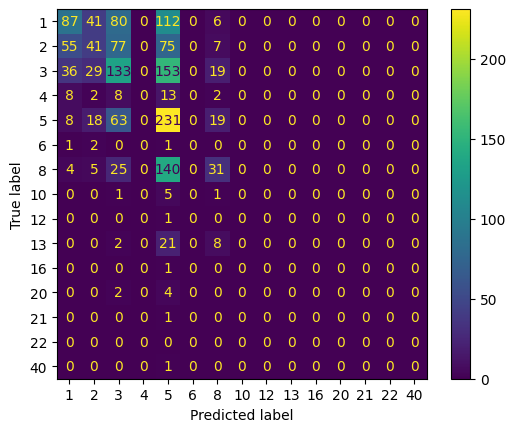

In [ ]:
labels = [1,2,3,4,5,6,8,10,12,13,16,20,21,22,40]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [ ]:
# Assuming y_test and y_pred are already defined from your previous code.
results_df = pd.DataFrame({'Real': y_test, 'Predicted': y_pred})
results_df

,Real,Predicted
id,,
9772,8,3
4086,5,2
4545,3,3
2353,2,2
9519,2,2
...,...,...
1842,2,2
6831,5,1
4292,8,5


In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test.index

# Display the resulting DataFrame
results_onlyP

,Predicted
id,
9772,3
4086,2
4545,3
2353,2
9519,2
...,...
1842,2
6831,1
4292,5


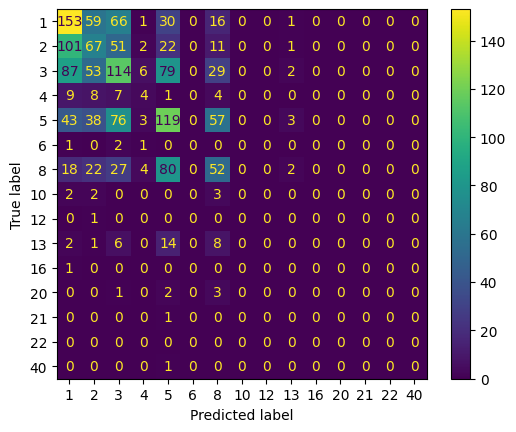

In [ ]:
labels = [1,2,3,4,5,6,8,10,12,13,16,20,21,22,40]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

Guardo 1ra predicción con Test

In [ ]:
joblib.dump(clf, 'BayesN_v5_text.joblib')

['BayesN_v5_text.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

In [ ]:
df_test['text'] = df_test['title'] + ' ' + df_test['description']
X_test_text = df_test.text
X_test_BN = vectorizer.transform(X_test_text)

In [ ]:
results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': y_pred})

In [ ]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)
# Save
joblib.dump(clf, 'BayesN_v4.joblib')

['BayesN_v4.joblib']

###Ensamble de mejores modelos de descrption y title

In [ ]:
# Verificar el tamaño de los conjuntos de prueba
print("Tamaño de X_test_title:", X_test_title.shape[0])
print("Tamaño de X_test_text:", X_test_text.shape[0])


Tamaño de X_test_title: 1559
Tamaño de X_test_text: 1975


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


# Paso 1: Obtener predicciones de ambos modelos en el conjunto de entrenamiento

# Modelo 1: Usando la columna title
count_vect_title = CountVectorizer(preprocessor=clean_text,
                                   tokenizer=tokenizer_v2,
                                   min_df=1,
                                   stop_words=stoplist_tokenized,
                                   ngram_range=(1,2))
X_train_title_ngrams = count_vect_title.fit_transform(X_train_title)
clf_title = MultinomialNB(alpha=1).fit(X_train_title_ngrams, y_train)

# Predicciones en el conjunto de entrenamiento para el modelo de "title"
train_pred_title = clf_title.predict(X_train_title_ngrams)

# Modelo 2: Usando la columna description
count_vect_desc = CountVectorizer(preprocessor=clean_text,
                                  tokenizer=tokenizer_v2,
                                  min_df=1,
                                  stop_words=stoplist_tokenized,
                                  ngram_range=(1,2))
X_train_desc_ngrams = count_vect_desc.fit_transform(X_train_text)
clf_desc = MultinomialNB(alpha=1).fit(X_train_desc_ngrams, y_train)

# Predicciones en el conjunto de entrenamiento para el modelo de "description"
train_pred_desc = clf_desc.predict(X_train_desc_ngrams)

# Paso 2: Crear un DataFrame con las predicciones de ambos modelos en el conjunto de entrenamiento
import pandas as pd
meta_train = pd.DataFrame({
    'pred_title': train_pred_title,
    'pred_description': train_pred_desc
})

# Paso 3: Entrenar el modelo meta con las predicciones anteriores
meta_model = LinearRegression()  # Usamos regresión para predecir valores continuos
meta_model.fit(meta_train, y_train)

# Paso 4: Obtener las predicciones de ambos modelos en el conjunto de prueba
X_test_title_ngrams = count_vect_title.transform(X_test_title)
test_pred_title = clf_title.predict(X_test_title_ngrams)

X_test_desc_ngrams = count_vect_desc.transform(X_test_description)
test_pred_desc = clf_desc.predict(X_test_desc_ngrams)

# Crear el conjunto de prueba para el modelo meta
meta_test = pd.DataFrame({
    'pred_title': test_pred_title,
    'pred_description': test_pred_desc
})

# Paso 5: Hacer la predicción final en el conjunto de prueba usando el modelo meta
y_pred_meta = meta_model.predict(meta_test)

# Calcular el RMSE en el conjunto de prueba
rmse_ensamble_description_title = np.sqrt(mean_squared_error(y_test, y_pred_meta))
print("RMSE del modelo meta:", rmse_ensamble_description_title)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RMSE del modelo meta: 2.246446800545055


Guardo prediccion

In [ ]:
import pandas as pd
df=pd.read_csv("test.csv")

# Paso 1: Preprocesar las columnas del nuevo DataFrame
df['text_title'] = df['title'].apply(clean_text)
df['text_description'] = df['description'].apply(clean_text)

# Paso 2: Convertir las columnas a n-gramas usando los mismos vectores entrenados
X_new_title_ngrams = count_vect_title.transform(df['text_title'])
X_new_desc_ngrams = count_vect_desc.transform(df['text_description'])

# Paso 3: Obtener predicciones de los modelos base
pred_title = clf_title.predict(X_new_title_ngrams)
pred_description = clf_desc.predict(X_new_desc_ngrams)

# Paso 4: Crear un DataFrame con las predicciones de los modelos base
meta_input = pd.DataFrame({
    'pred_title': pred_title,
    'pred_description': pred_description
})

# Paso 5: Obtener predicciones finales usando el modelo meta
final_predictions = meta_model.predict(meta_input)

# Paso 6: Mapear las predicciones al valor más cercano de los permitidos (1, 2, 3, 5, 8, 13)
allowed_values = np.array([1, 2, 3, 5, 8, 13])

def map_to_closest(value, allowed_values):
    return allowed_values[np.argmin(np.abs(allowed_values - value))]

mapped_predictions = np.array([map_to_closest(pred, allowed_values) for pred in final_predictions])

# Paso 7: Crear el DataFrame de salida con id y storypoints predichos
result_df = pd.DataFrame({
    'id': df['id'],
    'predicted_storypoint': mapped_predictions
})

In [ ]:
result_df = result_df.set_index('id')

In [ ]:
result_df

,predicted_storypoint
id,
3433,5
106,3
7182,2
8985,2
2149,3
...,...
9069,2
3100,2
6648,2


Usando el preprocesamiento de numeros fibonnaci

In [ ]:
# #SI USO EL SET DE TITLE
count_vect = CountVectorizer(preprocessor=clean_text,
                              tokenizer=tokenizer,
                              min_df=1,
                              stop_words=stoplist_tokenized,
                              ngram_range=(1,2))

X_train_ngrams = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario
print(">> Número de features = ",X_train_ngrams.shape[1])

 #entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)

#predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)

# veo el reporte de clasificación
print(classification_report(y_test, y_pred))



accuracy = accuracy_score(y_pred, y_test)
F1 = f1_score(y_pred, y_test, average="weighted")
RMSE = root_mean_squared_error(y_pred, y_test)

print("Accuracy:", accuracy)
print("F1 Score:", F1)
print("RMSE:", RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


>> Número de features =  161495
              precision    recall  f1-score   support

           1       0.56      0.36      0.43       652
           2       0.51      0.20      0.29       510
           3       0.38      0.59      0.46       806
           5       0.40      0.63      0.49       677
           8       0.54      0.23      0.32       410
          13       1.00      0.03      0.06        62

    accuracy                           0.43      3117
   macro avg       0.56      0.34      0.34      3117
weighted avg       0.48      0.43      0.41      3117

Accuracy: 0.4273339749759384
F1 Score: 0.44781261715180587
RMSE: 2.3023052709132243


###Conclusión
* El ensamblado de los dos mejores modelos de descrption y title da un resultado mejor:
* De la concatenación de las dos columnas en una sola se obtuvo una mejor que usando sólo una columna. Pero el ensamble de descption y title es un poco mejor.

In [ ]:
print("RMSE del modelo ensamble title y description:", rmse_ensamble_description_title)

RMSE del modelo ensamble title y description: 2.248795202608666


## Modelo: XGBoost

###XGBoost v1

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score, root_mean_squared_error
    ,mean_absolute_error
)

count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_xgboost = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario

first_model = xgb.XGBRegressor()
scores_cv_xgboost = cross_val_score(first_model,X_train_xgboost, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_xgboost.mean(),4)," ( sd =",round(scores_cv_xgboost.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE= -2.2837  ( sd = 0.0413 )


In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train_xgboost,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_test_xgboost = count_vect.transform(X_test_text)
preds = xgbr.predict(X_test_xgboost)

In [ ]:
# #Veo los errores para los valores observados y los predichos para el set de test
RMSE = root_mean_squared_error(preds, y_test)
print("RMSE:", RMSE)

RMSE: 2.282052344919502


In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_xgboost = count_vect.fit_transform(X_train_text)
X_test_xgboost = count_vect.transform(X_test_text)

modelo_xgb = xgb.XGBRegressor().fit(X_train_xgboost, y_train)

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = modelo_xgb.predict(X_test_xgboost).round().astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test.index

# Display the resulting DataFrame
results_onlyP

,Predicted
11035,5
7808,3
15279,3
7324,4
3748,3
...,...
5135,2
3892,3
11156,2
4176,3


Guardo la prediccion

In [ ]:
joblib.dump(modelo_xgb, 'XGBoost_v1.joblib')

['XGBoost_v1.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.description
X_test_xgboost = count_vect.transform(X_test_text)

In [ ]:
# Load the saved model
clf = joblib.load('XGBoost_v1.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_xgboost).round().astype(int)
results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': y_pred})
results.to_csv('XGBoost_v1.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,6
106,3
7182,3
8985,3
2149,2
...,...
9069,2
3100,4
6648,3


###XGBoost v2

XGBoost_v2 y dio el score 2.80 en kaggle

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Primero, el CountVectorizer y la función de limpieza de texto.
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=17,  # Limita el número de ocurrencias para que un n-grama sea considerado
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),  # Usamos unigramas y bigramas
)

# Transformamos los datos de texto en características numéricas
X_train_xgboost = count_vect.fit_transform(X_train_descrption)

# Definir el modelo XGBoost
second_model = xgb.XGBRegressor()

# Evaluar el modelo con validación cruzada usando RMSE
scores_cv_xgboost = cross_val_score(second_model, X_train_xgboost, y_train_orginal, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE = ", round(scores_cv_xgboost.mean(), 4), " (sd =", round(scores_cv_xgboost.std(), 4), ")")

# **Optimización de hiperparámetros con RandomizedSearchCV**

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Probar tasas de aprendizaje más bajas
    'n_estimators': [100, 200, 400, 600],  # Experimentar con diferentes números de estimadores
    'max_depth': [3, 6, 8, 10],  # Profundidad de los árboles
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporción de muestras a usar
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporción de características a usar por árbol
    'min_child_weight': [1, 3, 5, 10],  # Peso mínimo de un nodo hijo
    'gamma': [0, 0.1, 0.2, 0.5],  # Gamma para la regularización
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}

# Usamos RandomizedSearchCV para la búsqueda de hiperparámetros

random_search = RandomizedSearchCV(
    second_model,  # El modelo que usamos
    param_distributions=param_dist,  # Distribuciones de los hiperparámetros
    n_iter=10,  # ajustar según el caso
    cv=5,  # Validación cruzada
    scoring='neg_root_mean_squared_error',  # Métrica RMSE negativa para regresión
    verbose=2,  # Proveer más detalles sobre el progreso
    n_jobs=-1,  # Usamos todos los núcleos disponibles para acelerar la búsqueda
    random_state=42,  # Asegura la reproducibilidad de los resultados
)

# Ajustamos el modelo con RandomizedSearchCV
random_search.fit(X_train_xgboost, y_train_orginal)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search.best_params_)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Evaluar el modelo optimizado con validación cruzada usando RMSE
scores_cv_best_model = cross_val_score(best_model, X_train_xgboost, y_train_orginal, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE (modelo optimizado) = ", round(scores_cv_best_model.mean(), 4), " (sd =", round(scores_cv_best_model.std(), 4), ")")

# Finalmente, podemos obtener otras métricas para evaluar el modelo

# Predicciones en el conjunto de entrenamiento para calcular otras métricas
y_pred = best_model.predict(X_train_xgboost)

# Calcular R2
r2 = r2_score(y_train_orginal, y_pred)
print(f"R2 Score: {r2:.4f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_train_orginal, y_pred)
print(f"MAE: {mae:.4f}")

# Calcular RMSE
rmse_xgboost_v2 = mean_squared_error(y_train_orginal, y_pred, squared=False)
print(f"RMSE: {rmse_xgboost_v2:.4f}")

NEG RMSE =  -2.3242  (sd = 0.0908 )
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros encontrados:  {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
NEG RMSE (modelo optimizado) =  -2.2807  (sd = 0.0987 )
R2 Score: 0.5289
MAE: 1.3209
RMSE: 1.7675


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
joblib.dump(best_model, 'XGBoost_v2.joblib')

['XGBoost_v2.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.description
X_test_xgboost = count_vect.transform(X_test_text)

In [ ]:
# Load the saved model
clf = joblib.load('XGBoost_v2.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_xgboost).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': y_pred})
results.to_csv('XGBoost_v2.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,5
106,3
7182,3
8985,3
2149,2
...,...
9069,4
3100,3
6648,3


###XGBoost v3
submission_v3 y dio 2.91

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Primero, el CountVectorizer y la función de limpieza de texto.
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=17,  # Limita el número de ocurrencias para que un n-grama sea considerado
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),  # Usamos unigramas y bigramas
)

# Transformamos los datos de texto en características numéricas
X_train_xgboost = count_vect.fit_transform(X_train_text)

# Definir el modelo XGBoost
second_model = xgb.XGBRegressor()

# Evaluar el modelo con validación cruzada usando RMSE
scores_cv_xgboost = cross_val_score(second_model, X_train_xgboost, y_train, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE = ", round(scores_cv_xgboost.mean(), 4), " (sd =", round(scores_cv_xgboost.std(), 4), ")")

# **Optimización de hiperparámetros con RandomizedSearchCV**

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Probar tasas de aprendizaje más bajas
    'n_estimators': [100, 200, 400, 600],  # Experimentar con diferentes números de estimadores
    'max_depth': [3, 6, 8, 10],  # Profundidad de los árboles
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporción de muestras a usar
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporción de características a usar por árbol
    'min_child_weight': [1, 3, 5, 10],  # Peso mínimo de un nodo hijo
    'gamma': [0, 0.1, 0.2, 0.5],  # Gamma para la regularización
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}

# Usamos RandomizedSearchCV para la búsqueda de hiperparámetros

random_search = RandomizedSearchCV(
    second_model,  # El modelo que estamos usando
    param_distributions=param_dist,  # Distribuciones de los hiperparámetros
    n_iter=17,  # ajustar según el caso
    cv=5,  # Validación cruzada
    scoring='neg_root_mean_squared_error',  # Métrica RMSE negativa para regresión
    verbose=2,  # Proveer más detalles sobre el progreso
    n_jobs=-1,  # Usamos todos los núcleos disponibles para acelerar la búsqueda
    random_state=42,  # Asegura la reproducibilidad de los resultados
)

# Ajustamos el modelo con RandomizedSearchCV
random_search.fit(X_train_xgboost, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search.best_params_)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Evaluar el modelo optimizado con validación cruzada usando RMSE
scores_cv_best_model = cross_val_score(best_model, X_train_xgboost, y_train, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE (modelo optimizado) = ", round(scores_cv_best_model.mean(), 4), " (sd =", round(scores_cv_best_model.std(), 4), ")")

# Finalmente, podemos obtener otras métricas para evaluar el modelo

# Predicciones en el conjunto de entrenamiento para calcular otras métricas
y_pred = best_model.predict(X_train_xgboost)

# Calcular R2
r2 = r2_score(y_train, y_pred)
print(f"R2 Score: {r2:.4f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_train, y_pred)
print(f"MAE: {mae:.4f}")

# Calcular RMSE
rmse_xgboost_v2 = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE: {rmse_xgboost_v2:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE =  -2.2837  (sd = 0.0413 )
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros encontrados:  {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
NEG RMSE (modelo optimizado) =  -2.2565  (sd = 0.0312 )
R2 Score: 0.4562
MAE: 1.3969
RMSE: 1.8990


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model.fit(X_train_xgboost, y_train)

# Guardamos el modelo entrenado
joblib.dump(best_model, 'xgboost_model_v2.joblib')

# Cargamos el conjunto de datos de prueba
df_test = pd.read_csv("test.csv")
df_test.set_index('id', inplace=True)
X_test_text = df_test.description

# Transformamos los datos de prueba con el mismo CountVectorizer que usamos en el entrenamiento
X_test_xgboost = count_vect.transform(X_test_text)

# Cargamos el modelo guardado
loaded_model = joblib.load('xgboost_model_v2.joblib')

# Hacemos predicciones en el conjunto de datos de prueba
y_pred = loaded_model.predict(X_test_xgboost).round().astype(int)

# Creamos un DataFrame con las predicciones
results_df = pd.DataFrame({'Predicted': y_pred})
results_df.index = X_test_text.index

# Mostramos el DataFrame
results_df

,Predicted
id,
3433,5
106,3
7182,3
8985,3
2149,2
...,...
9069,3
3100,4
6648,3


###XGBoost v4
Sólo con title

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Primero, el CountVectorizer y la función de limpieza de texto.
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=8,  # Limita el número de ocurrencias para que un n-grama sea considerado
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),  # Usamos unigramas y bigramas
)

# Transformamos los datos de texto en características numéricas
X_train_xgboost = count_vect.fit_transform(X_train_title)

# Definir el modelo XGBoost
second_model = xgb.XGBRegressor()

# Evaluar el modelo con validación cruzada usando RMSE
scores_cv_xgboost = cross_val_score(second_model, X_train_xgboost, y_train_orginal, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE = ", round(scores_cv_xgboost.mean(), 4), " (sd =", round(scores_cv_xgboost.std(), 4), ")")

# **Optimización de hiperparámetros con RandomizedSearchCV**

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Probar tasas de aprendizaje más bajas
    'n_estimators': [100, 200, 400, 600],  # Experimentar con diferentes números de estimadores
    'max_depth': [3, 6, 8, 10],  # Profundidad de los árboles
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporción de muestras a usar
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporción de características a usar por árbol
    'min_child_weight': [1, 3, 5, 10],  # Peso mínimo de un nodo hijo
    'gamma': [0, 0.1, 0.2, 0.5],  # Gamma para la regularización
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}

# Usamos RandomizedSearchCV para la búsqueda de hiperparámetros

random_search = RandomizedSearchCV(
    second_model,
    param_distributions=param_dist,  # Distribuciones de los hiperparámetros
    n_iter=17,  # ajustar según el caso
    cv=10,  # Validación cruzada
    scoring='neg_root_mean_squared_error',  # Métrica RMSE negativa para regresión
    verbose=2,  # Proveer más detalles sobre el progreso
    n_jobs=-1,  # Usamos todos los núcleos disponibles para acelerar la búsqueda
    random_state=42,  # Asegura la reproducibilidad de los resultados
)

# Ajustamos el modelo con RandomizedSearchCV
random_search.fit(X_train_xgboost, y_train_orginal)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search.best_params_)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Evaluar el modelo optimizado con validación cruzada usando RMSE
scores_cv_best_model = cross_val_score(best_model, X_train_xgboost, y_train_orginal, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE (modelo optimizado) = ", round(scores_cv_best_model.mean(), 4), " (sd =", round(scores_cv_best_model.std(), 4), ")")

# Finalmente, podemos obtener otras métricas para evaluar el modelo

# Predicciones en el conjunto de entrenamiento para calcular otras métricas
y_pred = best_model.predict(X_train_xgboost)

# Calcular R2
r2 = r2_score(y_train_orginal, y_pred)
print(f"R2 Score: {r2:.4f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_train_orginal, y_pred)
print(f"MAE: {mae:.4f}")

# Calcular RMSE
rmse = mean_squared_error(y_train_orginal, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE =  -2.3323  (sd = 0.0951 )
Fitting 10 folds for each of 17 candidates, totalling 170 fits
Mejores hiperparámetros encontrados:  {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
NEG RMSE (modelo optimizado) =  -2.3043  (sd = 0.1034 )
R2 Score: 0.3722
MAE: 1.5046
RMSE: 2.0404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
joblib.dump(best_model, 'XGBoost_v4.joblib')

['XGBoost_v4.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.title
X_test_xgboost = count_vect.transform(X_test_text)

In [ ]:

# Load the saved model
clf = joblib.load('XGBoost_v4.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_xgboost).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': y_pred})
results.to_csv('XGBoost_v4.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,7
106,3
7182,3
8985,5
2149,3
...,...
9069,5
3100,3
6648,3


###XGBoost v5
Solo con description

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score, root_mean_squared_error
    ,mean_absolute_error
)

count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_xgboost = count_vect.fit_transform(X_train_descrption) # cuenta frecuencia de tokens y define el diccionario

first_model = xgb.XGBRegressor()
scores_cv_xgboost = cross_val_score(first_model,X_train_xgboost, y_train_orginal,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_xgboost.mean(),4)," ( sd =",round(scores_cv_xgboost.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE= -2.3158  ( sd = 0.0886 )


### XGBoost v6 - Classifier

In [ ]:
X_train_text.tolist()[:15]

['slave recovery test multiple frameworks flaky gtest repeat gtest shuffle gtest break failure noformat run slave recovery test multiple frameworks warning logging before init google logging written stderr exec cpp version exec cpp executor registered slave registered executor artoo starting task 51991f97 f5fd ad0f 02668083af7c forked command sleep warning logging before init google logging written stderr exec cpp version exec cpp executor registered slave registered executor artoo starting task eaf5d8d6 3a6c 4ee1 84c1 fae20fb1df83 sleep forked command exec cpp received reconnect request from slave exec cpp received reconnect request from slave exec cpp executor registered slave registered executor artoo exec cpp executor asked shutdown shutting down sending sigterm process tree pid killing the following process trees sleep sleep src tests slave recovery tests cpp failure value status1 get state actual task failed expected task killed program received signal sigsegv segmentation fault 

In [ ]:
X_train_text = X_train_text.apply(clean_text)

<ipython-input-70-f80786c65768>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


In [ ]:
X_train_text.tolist()[:5]

['slave recovery test multiple frameworks flaky gtest repeat gtest shuffle gtest break failure noformat run slave recovery test multiple frameworks warning logging before init google logging written stderr exec cpp version exec cpp executor registered slave registered executor artoo starting task 51991f97 f5fd ad0f 02668083af7c forked command sleep warning logging before init google logging written stderr exec cpp version exec cpp executor registered slave registered executor artoo starting task eaf5d8d6 3a6c 4ee1 84c1 fae20fb1df83 sleep forked command exec cpp received reconnect request from slave exec cpp received reconnect request from slave exec cpp executor registered slave registered executor artoo exec cpp executor asked shutdown shutting down sending sigterm process tree pid killing the following process trees sleep sleep src tests slave recovery tests cpp failure value status1 get state actual task failed expected task killed program received signal sigsegv segmentation fault 

In [ ]:
vectorizer = TfidfVectorizer(preprocessor=clean_text, max_features=200,
                             ngram_range=(1, 2), analyzer='word', stop_words='english')

X = vectorizer.fit_transform(df['text']).toarray()  # Representación numérica del texto
y = df['storypoint']  # Etiqueta de predicción

<ipython-input-70-f80786c65768>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


In [ ]:
# División de datos conservando ambas columnas y manteniendo el índice alineado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=1310)


In [ ]:
model_xgb_class = xgb.XGBClassifier (objective='multi:softmax', eval_metric='rmse',
    use_label_encoder=False,random_state=47)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encod = le.fit_transform(y_train)

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),        # Number of boosting rounds
    'max_depth': randint(3, 10),            # Maximum depth of a tree
    'learning_rate': uniform(0.01, 0.2),    # Learning rate (shrinkage)2
    'gamma': uniform(0, 5),                 # Minimum loss reduction to make a split
    'min_child_weight': randint(1, 10),     # Minimum sum of instance weight (hessian)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb_class,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_root_mean_squared_error',
    cv=7,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model
random_search.fit(X_train, y_train_encod)

# Best parameters and best model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate on the test set
y_pred_encod = best_model.predict(X_test)
y_pred = le.inverse_transform(y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
y_pred = model_xgb_class.predict(X_test)

In [ ]:
scores_cv_xgboost = cross_val_score(model_xgb_class,X_train, y_train,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_xgboost.mean(),4)," ( sd =",round(scores_cv_xgboost.std(),4),")")

NEG RMSE= -1.5178  ( sd = 0.0587 )


In [ ]:
joblib.dump(model_xgb_class, 'XGBoost_clasifier.joblib')

['XGBoost_clasifier.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

df_test['text'] = df_test['title'] + ' ' + df_test['description']
X_test_text = df_test.text
X_test_text = vectorizer.transform(X_test_text)

<ipython-input-70-f80786c65768>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


In [ ]:
# Load the saved model
clf = joblib.load('XGBoost_clasifier.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_text)

y_pred_original = le.inverse_transform(y_pred)

In [ ]:
y_pred_original

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
# Creamos un DataFrame con las predicciones
results_df = pd.DataFrame({'Predicted': y_pred_original})
results_df.index = df_test.index

# Mostramos el DataFrame
results_df.value_counts()

,count
Predicted,
2,1895
3,72
1,5
13,2
5,1


In [ ]:
results_df

,Predicted
id,
3433,2
106,2
7182,2
8985,2
2149,2
...,...
9069,2
3100,2
6648,2


In [ ]:
# Rename the 'Predicted' column to 'storypoint'
results_df = results_df.rename(columns={'Predicted': 'storypoint'})

# Save the modified DataFrame to a CSV file
results_df.to_csv('output.csv', index=False) # Set index=False to avoid writing row indices to the file

In [ ]:
results_df

,storypoint
id,
3433,2
106,2
7182,2
8985,2
2149,2
...,...
9069,2
3100,2
6648,2


In [ ]:
results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': y_pred})
results.to_csv('XGBoost_v4.csv', index=False)

### XGBoost v7 (Mejor de Kaggle)
XGBoost optimizo hiperparámetros + usa description + tockenizer versión 3
Tardó 1:37:00 en correr

In [ ]:
def clean_text(text):
  return text.strip()

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def tokenizer_v3(text):
    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar caracteres no alfabéticos (salvo espacios)
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)

    # Tokenización
    tokens = word_tokenize(text)

    # Filtrar palabras vacías y lematizar las palabras restantes
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha()]

    return tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Primero, el CountVectorizer y la función de limpieza de texto.
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer_v3,
    min_df=17,  # Limita el número de ocurrencias para que un n-grama sea considerado
    stop_words=stoplist_tokenized_v3,
    ngram_range=(1, 2),  # Usamos unigramas y bigramas
)

# Transformamos los datos de texto en características numéricas
X_train_xgboost = count_vect.fit_transform(X_train_text)

# Definir el modelo XGBoost
third_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6)

# Evaluar el modelo con validación cruzada usando RMSE
scores_cv_xgboost = cross_val_score(third_model ,X_train_xgboost, y_train, cv=10, scoring='neg_root_mean_squared_error')
print("NEG RMSE = ", round(scores_cv_xgboost.mean(), 4), " (sd =", round(scores_cv_xgboost.std(), 4), ")")

# **Optimización de hiperparámetros con RandomizedSearchCV**

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Probar tasas de aprendizaje más bajas
    'n_estimators': [100, 200, 400, 600, 1000, 1500],  # Experimentar con diferentes números de estimadores
    'max_depth': [3, 6, 8, 10],  # Profundidad de los árboles
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporción de muestras a usar
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporción de características a usar por árbol
    'min_child_weight': [1, 3, 5, 10],  # Peso mínimo de un nodo hijo
    'gamma': [0, 0.1, 0.2, 0.5],  # Gamma para la regularización
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}

# Usamos RandomizedSearchCV para la búsqueda de hiperparámetros

random_search = RandomizedSearchCV(
    third_model,  # El modelo que estamos ajustando
    param_distributions=param_dist,  # Distribuciones de los hiperparámetros
    n_iter=50,  # Aumentamos el número de iteraciones para explorar más combinaciones
    cv=10,  # Validación cruzada de 10 pliegues para obtener mejores resultados
    scoring='neg_root_mean_squared_error',  # Métrica RMSE negativa para regresión
    verbose=3,  # Más detalles sobre el progreso del ajuste
    n_jobs=-1,  # Usamos todos los núcleos disponibles para acelerar la búsqueda
    random_state=42,  # Asegura la reproducibilidad de los resultados
)

# Ajustamos el modelo con RandomizedSearchCV
random_search.fit(X_train_xgboost, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search.best_params_)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Evaluar el modelo optimizado con validación cruzada usando RMSE
scores_cv_best_model = cross_val_score(best_model, X_train_xgboost, y_train, cv=10, scoring='neg_root_mean_squared_error')
print("NEG RMSE (modelo optimizado) = ", round(scores_cv_best_model.mean(), 4), " (sd =", round(scores_cv_best_model.std(), 4), ")")

# Finalmente, podemos obtener otras métricas para evaluar el modelo

# Predicciones en el conjunto de entrenamiento para calcular otras métricas
y_pred = best_model.predict(X_train_xgboost)

# Calcular R2
r2 = r2_score(y_train, y_pred)
print(f"R2 Score: {r2:.4f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_train, y_pred)
print(f"MAE: {mae:.4f}")

# Calcular RMSE
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'wa'] not in stop_words.
  warnings.warn(


NEG RMSE =  -2.6894  (sd = 0.2188 )
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados:  {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
NEG RMSE (modelo optimizado) =  -2.6527  (sd = 0.2168 )
R2 Score: 0.7130
MAE: 1.1872
RMSE: 1.5978


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model.fit(X_train_xgboost, y_train)

# Guardamos el modelo entrenado
joblib.dump(best_model, 'xgboost_model_v3.joblib')

# Cargamos el conjunto de datos de prueba
df_test = pd.read_csv("test.csv")
df_test.set_index('id', inplace=True)
X_test_text = df_test.description

# Transformamos los datos de prueba con el mismo CountVectorizer que usamos en el entrenamiento
X_test_xgboost = count_vect.transform(X_test_text)

# Cargamos el modelo guardado
loaded_model = joblib.load('xgboost_model_v3.joblib')

# Hacemos predicciones en el conjunto de datos de prueba
y_pred = loaded_model.predict(X_test_xgboost).round().astype(int)

# Creamos un DataFrame con las predicciones
results_df = pd.DataFrame({'Predicted': y_pred})
results_df.index = X_test_text.index

# Mostramos el DataFrame
results_df

,Predicted
id,
3433,5
106,3
7182,3
8985,3
2149,2
...,...
9069,4
3100,3
6648,3


###Conclusión
El mejor XGBoost nos da un rmse de test:  
* RMSE: 1.597
* kaggle: 2.783

##Modelo: Random Forest

###Primer modelo

In [ ]:
df = pd.read_csv("train.csv")
df.set_index('id', inplace=True)

X = df.description
y = df.storypoint


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#
# USO LA EL SET DE ENTRENAMIENTO Y DE TESTEO HECHO EN LA SECCION "CREACION DE CONJUNTOS TRAIN Y TEST"
#
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_rf)

rf_first_model = RandomForestRegressor()
scores_cv_rf = cross_val_score(rf_first_model,X_train_random_forest, y_train_rf,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_rf.mean(),4)," ( sd =",round(scores_cv_rf.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE= -2.8051  ( sd = 0.2042 )


In [ ]:
random_forest_v1 = RandomForestRegressor()
random_forest_v1.fit(X_train_random_forest, y_train_rf)

RandomForestRegressor()

In [ ]:
X_test_random_forest = count_vect.transform(X_test_rf)
preds_rf = random_forest_v1.predict(X_test_random_forest)

In [ ]:
# #Veo los errores para los valores observados y los predichos para el set de test
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score, root_mean_squared_error
    ,mean_absolute_error
)
RMSE = root_mean_squared_error(preds_rf, y_test_rf)
print("RMSE:", RMSE)

RMSE: 2.529914903782988


Armo el modelo

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_rf)
X_test_random_forest = count_vect.transform(X_test_rf)

modelo_rf_1 = RandomForestRegressor().fit(X_train_random_forest, y_train_rf)

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred_rf = modelo_rf_1.predict(X_test_random_forest).round().astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred_rf})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test_rf.index

# Display the resulting DataFrame
results_onlyP

,Predicted
id,
5889,4
6273,7
5084,4
8991,5
8637,3
...,...
5573,6
3619,2
2136,4


Guardo la prediccion

In [ ]:
joblib.dump(modelo_rf_1, 'RandomForest_v1.joblib')

['RandomForest_v1.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.description
X_test_random_forest = count_vect.transform(X_test_text)

In [ ]:
# Load the saved model
clf = joblib.load('RandomForest_v1.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
pred_rf = clf.predict(X_test_random_forest).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': pred_rf})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': pred_rf})
results.to_csv('RandomForest_v1.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,5
106,4
7182,2
8985,2
2149,2
...,...
9069,4
3100,3
6648,2


###RF v2 (mejor rf)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#
# USO LA EL SET DE ENTRENAMIENTO Y DE TESTEO HECHO EN LA SECCION "CREACION DE CONJUNTOS TRAIN Y TEST"
#
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17, #modifico el limite de n-values para que un n-grams sea considerado
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_descrption)

rf_first_model = RandomForestRegressor()
scores_cv_rf = cross_val_score(rf_first_model,X_train_random_forest, y_train_original,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_rf.mean(),4)," ( sd =",round(scores_cv_rf.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML

NEG RMSE= -2.2589  ( sd = 0.1098 )


In [ ]:
random_forest_v1 = RandomForestRegressor()
random_forest_v1.fit(X_train_random_forest, y_train_original)

RandomForestRegressor()

In [ ]:
X_test_random_forest = count_vect.transform(X_test_description)
preds_rf = random_forest_v1.predict(X_test_random_forest)

<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup

In [ ]:
# #Veo los errores para los valores observados y los predichos para el set de test
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score, root_mean_squared_error
    ,mean_absolute_error
)

RMSE = root_mean_squared_error(preds_rf, y_test)
print("RMSE:", RMSE)

R2 = r2_score(preds_rf, y_test)
print("R2:", R2)

MSE = mean_squared_error(preds_rf, y_test)
print("MSE:", MSE)

RMSE: 2.2492200128866973
R2: -1.3452511928342625
MSE: 5.058990666370034


Armo el modelo

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_descrption)
X_test_random_forest = count_vect.transform(X_test_description)

modelo_rf_1 = RandomForestRegressor().fit(X_train_random_forest, y_train_original)

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred_rf = modelo_rf_1.predict(X_test_random_forest).round().astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-28-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-28-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML

In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred_rf})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test.index

# Display the resulting DataFrame
results_onlyP

,Predicted
id,
9772,4
4086,4
4545,3
2353,3
9519,2
...,...
1842,3
6831,3
4292,5


 Guardo la prediccion

In [ ]:
joblib.dump(modelo_rf_1, 'RandomForest_v2_mejorRF.joblib')

['RandomForest_v2_mejorRF.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.description
X_test_random_forest = count_vect.transform(X_test_text)

<ipython-input-28-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-28-31be97743cb7>:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup construct

In [ ]:
# Load the saved model
clf = joblib.load('RandomForest_v2_mejorRF.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
pred_rf = clf.predict(X_test_random_forest).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': pred_rf})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': pred_rf})
results.to_csv('RandomForest_v2.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,5
106,4
7182,2
8985,6
2149,2
...,...
9069,4
3100,3
6648,2


###RF V3

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_title)

rf_third_model = RandomForestRegressor()
scores_cv_rf = cross_val_score(rf_third_model,X_train_random_forest, y_train_original,cv = 6, scoring='neg_root_mean_squared_error')
print("NEG RMSE=",round(scores_cv_rf.mean(),4)," ( sd =",round(scores_cv_rf.std(),4),")")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE= -2.4474  ( sd = 0.0961 )


In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 600],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['gini', 'sqrt'],
}

# Create a RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(
    estimator=rf_third_model,
    param_distributions=param_grid_rf,
    n_iter=17,
    scoring='neg_root_mean_squared_error',
    cv=6,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search_rf.fit(X_train_random_forest, y_train_original)

# Print the best hyperparameters found
print("Best hyperparameters for Random Forest:", random_search_rf.best_params_)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

# Evaluate the best model using cross-validation
scores_cv_best_rf = cross_val_score(best_rf_model, X_train_random_forest, y_train_original, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE (optimized Random Forest) =", round(scores_cv_best_rf.mean(), 4), "(sd =", round(scores_cv_best_rf.std(), 4), ")")

# Train the best model on the full training data
best_rf_model.fit(X_train_random_forest, y_train_original)

Fitting 6 folds for each of 17 candidates, totalling 102 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 102.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best hyperparameters for Random Forest: {'n_estimators': 600, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}
NEG RMSE (optimized Random Forest) = -2.3479 (sd = 0.1125 )


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=15, n_estimators=600)

In [ ]:
X_test_random_forest = count_vect.transform(X_test_title)


#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
pred_rf = best_rf_model.predict(X_test_random_forest).round().astype(int)

In [ ]:
rmse_rf_v3 = root_mean_squared_error(pred_rf, y_test)
print("RMSE:", rmse_rf_v3)

RMSE: 2.3445924025972764


In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=17,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))

X_train_random_forest = count_vect.fit_transform(X_train_title)
X_test_random_forest = count_vect.transform(X_test_title)

modelo_rf_3 = best_rf_model.fit(X_train_random_forest, y_train_original)

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred_rf = modelo_rf_3.predict(X_test_random_forest).round().astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Create a new DataFrame with 'id' and 'Predicted' columns
results_onlyP = pd.DataFrame({'Predicted': y_pred_rf})

# Reset the index of y_test to get the 'id' values back
results_onlyP.index = y_test.index

# Display the resulting DataFrame
results_onlyP

,Predicted
id,
9772,3
4086,3
4545,4
2353,4
9519,3
...,...
1842,3
6831,3
4292,5


In [ ]:
joblib.dump(best_rf_model, 'RandomForest_v3.joblib')

['RandomForest_v3.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_test_text = df_test.title
X_test_random_forest = count_vect.transform(X_test_text)

In [ ]:
# Load the saved model
clf = joblib.load('RandomForest_v3.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
pred_rf = clf.predict(X_test_random_forest).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': pred_rf})

results_onlyP.index = X_test_text.index

results_onlyP

results = pd.DataFrame({'id': X_test_text.index, 'storypoint': pred_rf})
results.to_csv('RandomForest_v3.csv', index=False)

In [ ]:
results_onlyP

,Predicted
id,
3433,5
106,3
7182,3
8985,4
2149,3
...,...
9069,3
3100,3
6648,4


##Redes Neuronales

Hay muchos modelos ya que cuesta encontrar los mejores hiperparametros en redes, lo que hicimos es probar con distintos modelos haciendo cambios en los hiperparametros.

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def plot_regression(modelo, x, y, title="", xlabel="x", ylabel="y"):
    plt.figure()
    plt.plot(y, modelo.predict(x), "o", label="Valores estimados")
    plt.plot(y, y, "-", label="Valores verdaderos")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


###Modelo 1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
columnas_predictoras = ['title', 'description']
variable_objetivo = 'storypoint'

test y train

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df_rn[columnas_predictoras],
    df_rn[variable_objetivo],
    test_size=0.2,
    random_state=42
)

####Preprocesamiento

Preprocesar textos con TF-IDF para cada columna separadamente

In [ ]:
tfidf_title = TfidfVectorizer(max_features=500)
x_train_title_tfidf = tfidf_title.fit_transform(x_train['title']).toarray()
x_test_title_tfidf = tfidf_title.transform(x_test['title']).toarray()

In [ ]:
tfidf_desc = TfidfVectorizer(max_features=500)
x_train_desc_tfidf = tfidf_desc.fit_transform(x_train['description']).toarray()
x_test_desc_tfidf = tfidf_desc.transform(x_test['description']).toarray()

Combinar representaciones en una sola matriz de características

In [ ]:
x_train_combined = np.hstack((x_train_title_tfidf, x_train_desc_tfidf))
x_test_combined = np.hstack((x_test_title_tfidf, x_test_desc_tfidf))

Escalar las características

In [ ]:
scaler = StandardScaler()
x_train_transform = scaler.fit_transform(x_train_combined)
x_test_transform = scaler.transform(x_test_combined)

####Modelo

*  Sequential: une las distintas capas de la red neuronal
* Dense=Fully conected  
Es el más básico que hace que todas las neuronas se comunican con todas la neuronas de la siguiente capa.  
* input_shape: Tamaño de entrada



Primer modelo haremos el más básico de básicos. Usaremos una sola neurona.

In [ ]:
valores_entrada = x_train_transform.shape[1]
valores_salida=1

modelo1 = keras.Sequential([
    keras.layers.Dense(valores_salida,input_shape=(valores_entrada,))]) #, activation="relu"

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Los mil y un parametros de entrada:
* Los mil valores distintos para las palabras que definimos en preprocesamiento
* Bias(sesgo)

In [ ]:
modelo1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,001 (3.91 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

####Configurar entrenamiento

* optimizer: Optimizadores. Hay varios para probar.
* learning_rate:  porcentaje de cambio con el que se actualizan los pesos en cada iteración

In [ ]:
modelo1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

Entrenamiento:
* Epocas: Cantidad de veces que se recorre todo el df.
* batch_size: Cada cuantas veces se actualizan los pesos.

In [ ]:
# Entrenamiento del modelo
modelo1.fit(x_train_transform,
            y_train,
            epochs=100,
            batch_size=16,
            verbose=False)

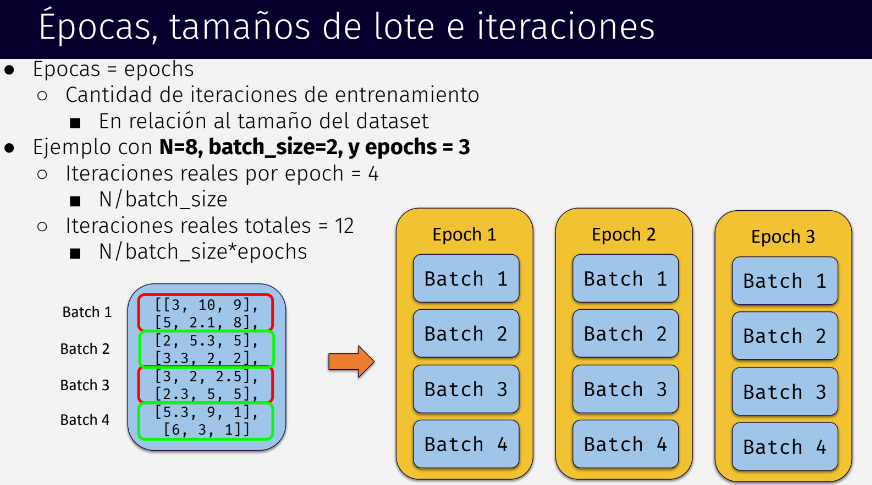

In [ ]:
mse, loss, rmse = modelo1.evaluate(x_test_transform, y_test)
print(f"MSE: {rmse:.4f}, Pérdida: {loss:.4f}, RMSE: {rmse:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 2.4085 - loss: 5.8169 - mae: 1.8184
MSE: 2.3726, Pérdida: 1.7890, RMSE: 2.3726


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


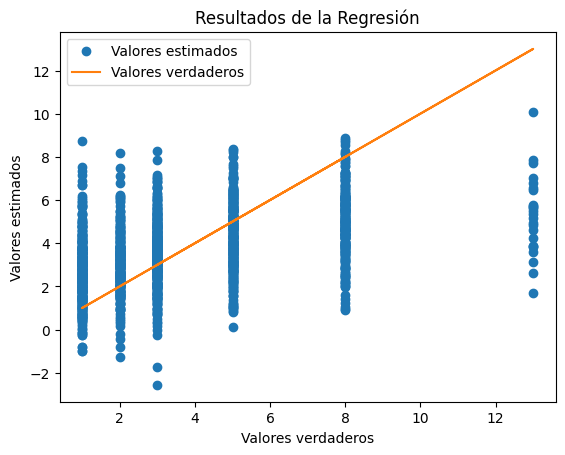

In [ ]:
plot_regression(modelo1, x_test_transform, y_test, title="Resultados de la Regresión", xlabel="Valores verdaderos", ylabel="Valores estimados")

####Conclusión
Termina resolviendo el problema como si fuera regresión lineal ya que no se le aregaron variables en función de activación.

###Modelo2
* Agregamos función de activación
* Más capas

In [ ]:
d_in=x_train_transform.shape[1]
d_out=1

modelo2 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(2, activation="tanh" ),
    keras.layers.Dense(d_out, )])

Ahora hay 3 capas

In [ ]:
modelo2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 2)                   │           2,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,011 (7.86 KB)

 Trainable params: 2,011 (7.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
modelo2.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

In [ ]:
y_pred_2 = modelo2.predict(x_test_transform)

mae = mean_absolute_error(y_test, y_pred_2)
mse = mean_squared_error(y_test, y_pred_2)
rmse = np.sqrt(mse)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error absoluto medio 1.8952845197369304
Error cuadrático medio 6.504857324031283
Raíz del error cuadrático medio (RMSE): 2.5504621785141772


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


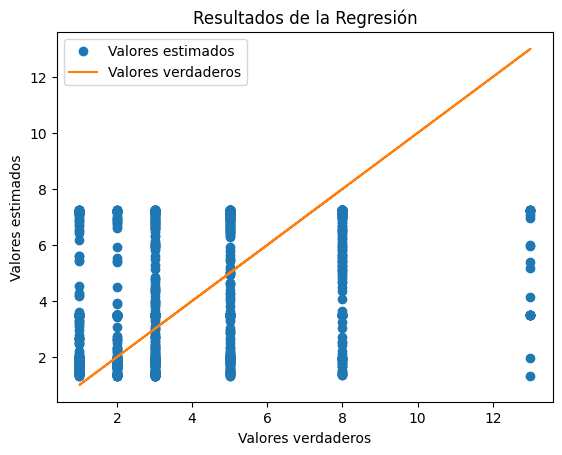

In [ ]:
plot_regression(modelo2, x_test_transform, y_test, title="Resultados de la Regresión", xlabel="Valores verdaderos", ylabel="Valores estimados")

###Modelo3

In [ ]:
from keras import initializers
# Creo un modelo Red Neuronal
d_in=x_train_transform.shape[1]
d_out=1


modelo3 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu",kernel_initializer= initializers.RandomNormal(stddev=0.01)),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu" ),
    keras.layers.Dense(d_out, )])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelo3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 2)                   │           2,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,203 (8.61 KB)

 Trainable params: 2,203 (8.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
modelo3.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

In [ ]:
y_pred_2 = modelo3.predict(x_test_transform)

mae = mean_absolute_error(y_test, y_pred_2)
mse = mean_squared_error(y_test, y_pred_2)
rmse = np.sqrt(mse)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error absoluto medio 2.0797073856388018
Error cuadrático medio 8.833903101760749
Raíz del error cuadrático medio (RMSE): 2.972188268222716


###Modelo 4

Mejora del modelo 3

In [ ]:
from keras import initializers
# Creo un modelo Red Neuronal
d_in=x_train_transform.shape[1]
d_out=1


modelo4 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu",kernel_initializer= 'glorot_normal'),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu" ),
    keras.layers.Dense(d_out, )])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelo4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 2)                   │           2,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,203 (8.61 KB)

 Trainable params: 2,203 (8.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo4.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
modelo4.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

In [ ]:
y_pred_2 = modelo4.predict(x_test_transform)

mae = mean_absolute_error(y_test, y_pred_2)
mse = mean_squared_error(y_test, y_pred_2)
rmse = np.sqrt(mse)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error absoluto medio 2.2791141407699294
Error cuadrático medio 9.992779637497554
Raíz del error cuadrático medio (RMSE): 3.161135814465673


###Modelo 5
Probando Regularización para evitar sobreajuste

In [ ]:
from keras import initializers
# Creo un modelo Red Neuronal
d_in=x_train_transform.shape[1]
d_out=1


modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu",kernel_initializer= 'glorot_normal'),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(d_out, )])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelo.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 2)                   │           2,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 50)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,203 (8.61 KB)

 Trainable params: 2,203 (8.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
modelo.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

In [ ]:
y_pred_2 = modelo.predict(x_test_transform)

mae = mean_absolute_error(y_test, y_pred_2)
mse = mean_squared_error(y_test, y_pred_2)
rmse = np.sqrt(mse)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error absoluto medio 2.0792059534401983
Error cuadrático medio 8.139687436175489
Raíz del error cuadrático medio (RMSE): 2.8530137462296756


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


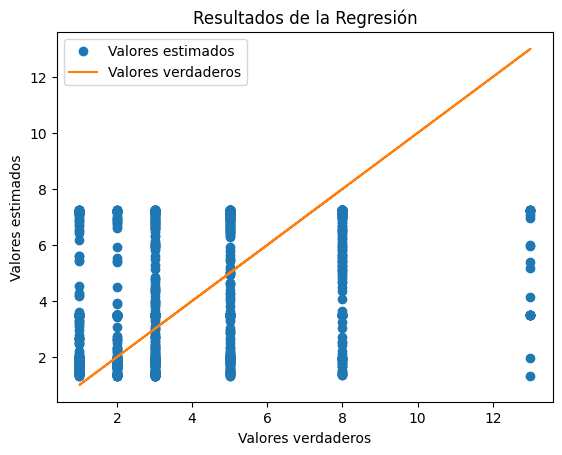

In [ ]:
plot_regression(modelo2, x_test_transform, y_test, title="Resultados de la Regresión", xlabel="Valores verdaderos", ylabel="Valores estimados")

###Modelo 6
Probamos otro preprocesamiento

####Preprocesamiento
Tokenización

Concatenación de las columnas que sirven para la predicción: title y description

In [ ]:
df_rn['text'] = df_rn['title'] + " " + df_rn['description']

train y tests

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df_rn['text'],
    df_rn['storypoint'],
    test_size=0.2,
    random_state=42
)

Tokenización

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  #usamos tokenizador de tensorflow
tokenizer.fit_on_texts(x_train)

Pasamos texto a secuencias

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [ ]:
maxlen = 100  #max long de las secuencias
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

convertimoa numpy

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

####Modelo Tradicional

In [ ]:
vocab_size = 10000
embedding_dim = 16

modelo = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
#Entrenar el modelo
historial = modelo.fit(x_train_pad, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_test_pad, y_test))

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - RootMeanSquaredError: 3.6977 - loss: 13.8415 - mae: 2.8123 - val_RootMeanSquaredError: 2.5602 - val_loss: 6.5544 - val_mae: 1.9325
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.4992 - loss: 6.2475 - mae: 1.9046 - val_RootMeanSquaredError: 2.4194 - val_loss: 5.8535 - val_mae: 1.8842
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.3729 - loss: 5.6332 - mae: 1.8042 - val_RootMeanSquaredError: 2.3632 - val_loss: 5.5846 - val_mae: 1.7987
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.3163 - loss: 5.3666 - mae: 1.7512 - val_RootMeanSquaredError: 2.3149 - val_loss: 5.3586 - val_mae: 1.8333
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.2774 - loss: 5.1908 - mae: 1.7165 - val_RootMeanSquaredError: 2.2674 - val_loss: 5.1413 - val_mae: 1.7578
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.1

####Conclusión

In [ ]:
from sklearn.metrics import r2_score

# Evaluar el modelo en el conjunto de prueba
mse, mae, rmse = modelo.evaluate(x_test_pad, y_test)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Predecir valores sobre el conjunto de prueba
y_pred = modelo.predict(x_test_pad)

# Calcular R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 2.2147 - loss: 4.9176 - mae: 1.6985
MSE: 4.8267, MAE: 1.6705, RMSE: 2.1970
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R²: 0.2721


Guardo prediccion de modelo 6

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Paso 1: Concatenar el texto
df_new=pd.read_csv("test.csv")
df_new['text'] = df_new['title'] + " " + df_new['description']

# Paso 2: Tokenizar usando el mismo tokenizer entrenado
new_seq = tokenizer.texts_to_sequences(df_new['text'])

# Paso 3: Paddear las secuencias
new_pad = pad_sequences(new_seq, maxlen=maxlen, padding='post', truncating='post')

# Paso 4: Realizar predicciones con el modelo entrenado
predictions = modelo.predict(new_pad)

# Paso 5: Redondear las predicciones a enteros
predicted_storypoints = np.round(predictions.flatten()).astype(int)

# Paso 6: Crear el DataFrame de salida sin índice
df_result = pd.DataFrame({
    'id': df_new['id'],
    'predicted_storypoint': predicted_storypoints
})

# Eliminar el índice del DataFrame
df_result.reset_index(drop=True, inplace=True)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
df_result

,id,predicted_storypoint
0,3433,6
1,106,2
2,7182,2
3,8985,3
4,2149,4
...,...,...
1970,9069,4
1971,3100,3
1972,6648,3
1973,6076,6


In [ ]:
df_result1=df_result.copy()

In [ ]:
df_result = df_result.set_index('id')

In [ ]:
df_result

,predicted_storypoint
id,
3433,6
106,2
7182,2
8985,3
2149,4
...,...
9069,4
3100,3
6648,3


###Modelo 7

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers

# Paso 1: Preprocesar los datos
# Dividir en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    df_rn[['title', 'description']],
    df_rn['storypoint'],
    test_size=0.2,
    random_state=42
)

# Tokenización para `title`
tokenizer_title = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_title.fit_on_texts(x_train['title'])
x_train_title_seq = tokenizer_title.texts_to_sequences(x_train['title'])
x_test_title_seq = tokenizer_title.texts_to_sequences(x_test['title'])

# Tokenización para `description`
tokenizer_desc = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_desc.fit_on_texts(x_train['description'])
x_train_desc_seq = tokenizer_desc.texts_to_sequences(x_train['description'])
x_test_desc_seq = tokenizer_desc.texts_to_sequences(x_test['description'])

# Padding para ambas entradas
maxlen_title = 30  # Longitud máxima para `title`
maxlen_desc = 100  # Longitud máxima para `description`
x_train_title_pad = pad_sequences(x_train_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_test_title_pad = pad_sequences(x_test_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_train_desc_pad = pad_sequences(x_train_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')
x_test_desc_pad = pad_sequences(x_test_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')

# Convertir etiquetas a arrays numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 2: Crear el modelo con dos entradas
vocab_size = 5000
embedding_dim = 16

# Entrada y procesamiento de `title`
input_title = layers.Input(shape=(maxlen_title,))
embedding_title = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_title)(input_title)
pool_title = layers.GlobalAveragePooling1D()(embedding_title)

# Entrada y procesamiento de `description`
input_desc = layers.Input(shape=(maxlen_desc,))
embedding_desc = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_desc)(input_desc)
pool_desc = layers.GlobalAveragePooling1D()(embedding_desc)

# Concatenación de ambos flujos
merged = layers.Concatenate()([pool_title, pool_desc])
dense_1 = layers.Dense(16, activation='relu')(merged)
output = layers.Dense(1)(dense_1)  # Salida para regresión

# Modelo
modelo = keras.Model(inputs=[input_title, input_desc], outputs=output)

modelo.summary()

modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

# Paso 4: Entrenar el modelo
historial = modelo.fit(
    [x_train_title_pad, x_train_desc_pad], y_train,
    epochs=10,
    batch_size=32,
    validation_data=([x_test_title_pad, x_test_desc_pad], y_test)
)

# Paso 5: Evaluar el modelo
rmse, loss, mae = modelo.evaluate([x_test_title_pad, x_test_desc_pad], y_test)
print(f"MSE: {rmse:.4f}, Pérdida: {loss:.4f}, RMSE: {mae:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 30, 16)         │         80,000 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 16)        │         80,000 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_1[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_2[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 16)             │            528 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             17 │ dense_15[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 160,545 (627.13 KB)

 Trainable params: 160,545 (627.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 3.3804 - loss: 11.5709 - mae: 2.5839 - val_RootMeanSquaredError: 2.6234 - val_loss: 6.8823 - val_mae: 2.0314
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.5626 - loss: 6.5784 - mae: 1.9846 - val_RootMeanSquaredError: 2.4939 - val_loss: 6.2196 - val_mae: 1.9689
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.4481 - loss: 5.9943 - mae: 1.8648 - val_RootMeanSquaredError: 2.3860 - val_loss: 5.6930 - val_mae: 1.8329
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - RootMeanSquaredError: 2.3429 - loss: 5.4919 - mae: 1.7661 - val_RootMeanSquaredError: 2.3513 - val_loss: 5.5286 - val_mae: 1.7398
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - RootMeanSquaredError: 2.2598 - loss: 5.1096 - mae: 1.7001 - val_RootMeanSquaredError: 2.2789 - val_loss: 5.1933 - val_mae: 1.7380
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.1

In [ ]:
mse, loss, rmse = modelo.evaluate([x_test_title_pad, x_test_desc_pad], y_test)
print(f"MSE: {mse:.4f}, Pérdida: {loss:.4f}, RMSE: {rmse:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 2.1970 - loss: 4.8342 - mae: 1.7212
MSE: 4.8369, Pérdida: 1.7084, RMSE: 2.1993


###Modelo 8
Busqueda de mejor cantidad de epochs

En el modelo 7 guardo el entrenamiento como historial.

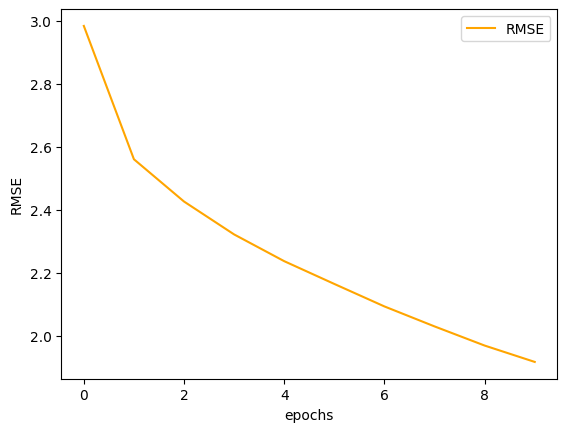

In [ ]:
cant_epochs=10
epochs = range(cant_epochs)

plt.plot(epochs, historial.history['RootMeanSquaredError'], color='orange', label='RMSE')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

Nuevo modelo

In [ ]:

# Paso 1: Preprocesar los datos
# Dividir en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    df_rn[['title', 'description']],
    df_rn['storypoint'],
    test_size=0.2,
    random_state=42
)

# Tokenización para `title`
tokenizer_title = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_title.fit_on_texts(x_train['title'])
x_train_title_seq = tokenizer_title.texts_to_sequences(x_train['title'])
x_test_title_seq = tokenizer_title.texts_to_sequences(x_test['title'])

# Tokenización para `description`
tokenizer_desc = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_desc.fit_on_texts(x_train['description'])
x_train_desc_seq = tokenizer_desc.texts_to_sequences(x_train['description'])
x_test_desc_seq = tokenizer_desc.texts_to_sequences(x_test['description'])

# Padding para ambas entradas
maxlen_title = 30  # Longitud máxima para `title`
maxlen_desc = 100  # Longitud máxima para `description`
x_train_title_pad = pad_sequences(x_train_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_test_title_pad = pad_sequences(x_test_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_train_desc_pad = pad_sequences(x_train_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')
x_test_desc_pad = pad_sequences(x_test_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')

# Convertir etiquetas a arrays numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 2: Crear el modelo con dos entradas
vocab_size = 5000
embedding_dim = 16

# Entrada y procesamiento de `title`
input_title = layers.Input(shape=(maxlen_title,))
embedding_title = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_title)(input_title)
pool_title = layers.GlobalAveragePooling1D()(embedding_title)

# Entrada y procesamiento de `description`
input_desc = layers.Input(shape=(maxlen_desc,))
embedding_desc = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_desc)(input_desc)
pool_desc = layers.GlobalAveragePooling1D()(embedding_desc)

# Concatenación de ambos flujos
merged = layers.Concatenate()([pool_title, pool_desc])
dense_1 = layers.Dense(16, activation='relu')(merged)
output = layers.Dense(1)(dense_1)  # Salida para regresión

# Modelo final
modelo = keras.Model(inputs=[input_title, input_desc], outputs=output)

modelo.summary()

modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

# Paso 4: Entrenar el modelo
cant_epochs=100

historial = modelo.fit(
    [x_train_title_pad, x_train_desc_pad], y_train,
    epochs=cant_epochs,
    batch_size=32,
    validation_data=([x_test_title_pad, x_test_desc_pad], y_test)
)

# Paso 5: Evaluar el modelo
rmse, loss, mae = modelo.evaluate([x_test_title_pad, x_test_desc_pad], y_test)
print(f"RMSE: {rmse:.4f}, Pérdida: {loss:.4f}, MAE: {mae:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 30, 16)         │         80,000 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 100, 16)        │         80,000 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_3[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_4[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32)             │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 16)             │            528 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1)              │             17 │ dense_17[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 160,545 (627.13 KB)

 Trainable params: 160,545 (627.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 3.3252 - loss: 11.2571 - mae: 2.5410 - val_RootMeanSquaredError: 2.6233 - val_loss: 6.8818 - val_mae: 2.1360
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.6072 - loss: 6.8015 - mae: 2.0245 - val_RootMeanSquaredError: 2.5067 - val_loss: 6.2834 - val_mae: 1.9439
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.4675 - loss: 6.0932 - mae: 1.8779 - val_RootMeanSquaredError: 2.4215 - val_loss: 5.8636 - val_mae: 1.8198
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.3299 - loss: 5.4304 - mae: 1.7637 - val_RootMeanSquaredError: 2.3468 - val_loss: 5.5074 - val_mae: 1.7971
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.2504 - loss: 5.0673 - mae: 1.6960 - val_RootMeanSquaredError: 2.2985 - val_loss: 5.2831 - val_mae: 1.7714
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredErro

Esta sobreajustado. Predice mejor con 10 epocas.

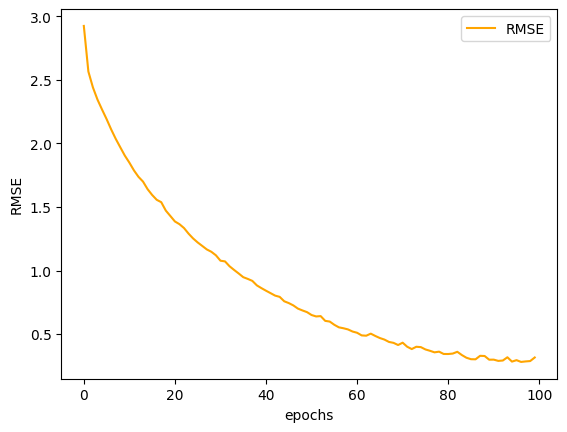

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historial.history['RootMeanSquaredError'], color='orange', label='RMSE')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

In [ ]:

# Paso 1: Preprocesar los datos
# Dividir en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    df_rn[['title', 'description']],
    df_rn['storypoint'],
    test_size=0.2,
    random_state=42
)

# Tokenización para `title`
tokenizer_title = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_title.fit_on_texts(x_train['title'])
x_train_title_seq = tokenizer_title.texts_to_sequences(x_train['title'])
x_test_title_seq = tokenizer_title.texts_to_sequences(x_test['title'])

# Tokenización para `description`
tokenizer_desc = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_desc.fit_on_texts(x_train['description'])
x_train_desc_seq = tokenizer_desc.texts_to_sequences(x_train['description'])
x_test_desc_seq = tokenizer_desc.texts_to_sequences(x_test['description'])

# Padding para ambas entradas
maxlen_title = 30  # Longitud máxima para `title`
maxlen_desc = 100  # Longitud máxima para `description`
x_train_title_pad = pad_sequences(x_train_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_test_title_pad = pad_sequences(x_test_title_seq, maxlen=maxlen_title, padding='post', truncating='post')
x_train_desc_pad = pad_sequences(x_train_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')
x_test_desc_pad = pad_sequences(x_test_desc_seq, maxlen=maxlen_desc, padding='post', truncating='post')

# Convertir etiquetas a arrays numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 2: Crear el modelo con dos entradas
vocab_size = 5000
embedding_dim = 16

# Entrada y procesamiento de `title`
input_title = layers.Input(shape=(maxlen_title,))
embedding_title = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_title)(input_title)
pool_title = layers.GlobalAveragePooling1D()(embedding_title)

# Entrada y procesamiento de `description`
input_desc = layers.Input(shape=(maxlen_desc,))
embedding_desc = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_desc)(input_desc)
pool_desc = layers.GlobalAveragePooling1D()(embedding_desc)

# Concatenación de ambos flujos
merged = layers.Concatenate()([pool_title, pool_desc])
dense_1 = layers.Dense(16, activation='relu')(merged)
output = layers.Dense(1)(dense_1)  # Salida para regresión

# Modelo final
modelo = keras.Model(inputs=[input_title, input_desc], outputs=output)

modelo.summary()

modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

# Paso 4: Entrenar el modelo
cant_epochs=25

historial = modelo.fit(
    [x_train_title_pad, x_train_desc_pad], y_train,
    epochs=cant_epochs,
    batch_size=32,
    validation_data=([x_test_title_pad, x_test_desc_pad], y_test)
)

# Paso 5: Evaluar el modelo
rmse, loss, mae = modelo.evaluate([x_test_title_pad, x_test_desc_pad], y_test)
print(f"RMSE: {rmse:.4f}, Pérdida: {loss:.4f}, RMSE: {mae:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 30, 16)         │         80,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 100, 16)        │         80,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_5[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ embedding_6[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 32)             │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 16)             │            528 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 1)              │             17 │ dense_19[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 160,545 (627.13 KB)

 Trainable params: 160,545 (627.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 3.4485 - loss: 12.0450 - mae: 2.6201 - val_RootMeanSquaredError: 2.6457 - val_loss: 7.0000 - val_mae: 2.0810
Epoch 2/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.6229 - loss: 6.8874 - mae: 2.0284 - val_RootMeanSquaredError: 2.5011 - val_loss: 6.2554 - val_mae: 2.0178
Epoch 3/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.4551 - loss: 6.0288 - mae: 1.8674 - val_RootMeanSquaredError: 2.3950 - val_loss: 5.7359 - val_mae: 1.8093
Epoch 4/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.3043 - loss: 5.3134 - mae: 1.7467 - val_RootMeanSquaredError: 2.3300 - val_loss: 5.4289 - val_mae: 1.7768
Epoch 5/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.2954 - loss: 5.2883 - mae: 1.7017 - val_RootMeanSquaredError: 2.2858 - val_loss: 5.2248 - val_mae: 1.7611
Epoch 6/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.2

Conclusión: En la búsqueda de la mejor cantidad de épocas, la que mejor resultado dio fue 10.

###Modelo 9
Mejora del modelo 6. Funcion para que solo prediga storypoints del 1 al 13 fibonacci

####Preprocesamiento
Tokenización

Concatenación de las columnas que sirven para la predicción: title y description

In [ ]:
df_rn['text'] = df_rn['title'] + " " + df_rn['description']

train y tests

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df_rn['text'],
    df_rn['storypoint'],
    test_size=0.2,
    random_state=42
)

Tokenización

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  #usamos tokenizador de tensorflow
tokenizer.fit_on_texts(x_train)

Pasamos texto a secuencias

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [ ]:
maxlen = 100  #max long de las secuencias
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

convertimoa numpy

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

####Modelo Tradicional

In [ ]:
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 16  # Dimensión del embedding

modelo = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    keras.layers.GlobalAveragePooling1D(),  # Reducimos la dimensionalidad de la salida
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss='mse',
               metrics=['mae', 'RootMeanSquaredError'])

In [ ]:
#Entrenar el modelo
historial = modelo.fit(x_train_pad, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_test_pad, y_test))

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - RootMeanSquaredError: 3.6663 - loss: 13.5311 - mae: 2.8150 - val_RootMeanSquaredError: 2.5749 - val_loss: 6.6301 - val_mae: 2.0008
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - RootMeanSquaredError: 2.4625 - loss: 6.0655 - mae: 1.8701 - val_RootMeanSquaredError: 2.4345 - val_loss: 5.9270 - val_mae: 1.9372
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - RootMeanSquaredError: 2.3760 - loss: 5.6465 - mae: 1.8031 - val_RootMeanSquaredError: 2.3691 - val_loss: 5.6127 - val_mae: 1.8474
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 2.3463 - loss: 5.5085 - mae: 1.7740 - val_RootMeanSquaredError: 2.3229 - val_loss: 5.3960 - val_mae: 1.8118
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 2.2559 - loss: 5.0921 - mae: 1.6941 - val_RootMeanSquaredError: 2.2845 - val_loss: 5.2190 - val_mae: 1.7621
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 2.1

####Conclusión

In [ ]:
mse, loss, rmse = modelo.evaluate(x_test_pad, y_test)
print(f"MSE: {mse:.4f}, Pérdida: {loss:.4f}, RMSE: {rmse:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 2.2249 - loss: 4.9628 - mae: 1.7163
MSE: 4.8628, Pérdida: 1.6857, RMSE: 2.2052


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Paso 1: Concatenar el texto
df_new = pd.read_csv("test.csv")
df_new['text'] = df_new['title'] + " " + df_new['description']

# Paso 2: Tokenizar usando el mismo tokenizer entrenado
new_seq = tokenizer.texts_to_sequences(df_new['text'])

# Paso 3: Paddear las secuencias
new_pad = pad_sequences(new_seq, maxlen=maxlen, padding='post', truncating='post')

# Paso 4: Realizar predicciones con el modelo entrenado
predictions = modelo.predict(new_pad).flatten()

# Paso 5: Función para mapear al valor más cercano permitido
allowed_values = np.array([1, 2, 3, 5, 8, 13])

def map_to_closest(value, allowed_values):
    return allowed_values[np.argmin(np.abs(allowed_values - value))]

# Aplicar la función a las predicciones
predicted_storypoints = np.array([map_to_closest(pred, allowed_values) for pred in predictions])

# Paso 6: Crear el DataFrame de salida sin índice
df_result = pd.DataFrame({
    'id': df_new['id'],
    'predicted_storypoint': predicted_storypoints
})



62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
df_result = df_result.set_index('id')

In [ ]:
df_result

,predicted_storypoint
id,
3433,8
106,2
7182,2
8985,3
2149,3
...,...
9069,5
3100,3
6648,3


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Paso 1: Concatenar el texto
df_new = pd.read_csv("test.csv")
df_new['text'] = df_new['title'] + " " + df_new['description']

# Paso 2: Tokenizar usando el mismo tokenizer entrenado
new_seq = tokenizer.texts_to_sequences(df_new['text'])

# Paso 3: Paddear las secuencias
new_pad = pad_sequences(new_seq, maxlen=maxlen, padding='post', truncating='post')

# Paso 4: Realizar predicciones con el modelo entrenado
predictions = modelo.predict(new_pad).flatten()

# Paso 5: Función para mapear los valores según las reglas
allowed_values = np.array([1, 3, 5, 8, 13])

def map_to_closest(value, allowed_values):
    if value > 13:
        return 13
    elif 3.5 <= value < 5:
        return 5
    else:
        return allowed_values[np.argmin(np.abs(allowed_values - value))]

# Aplicar la función a las predicciones
predicted_storypoints = np.array([map_to_closest(pred, allowed_values) for pred in predictions])

# Paso 6: Crear el DataFrame de salida sin índice
df_result = pd.DataFrame({
    'id': df_new['id'],
    'predicted_storypoint': predicted_storypoints
})


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
df_result = df_result.set_index('id')

In [ ]:
df_result

,predicted_storypoint
id,
3433,8
106,3
7182,1
8985,3
2149,5
...,...
9069,5
3100,3
6648,3


###Conclusión
El mejor modelo de Redes Neuronales es el modelo 6

##Embeddings


Descarga y prueba de que el embeddings GloVe preentrenado funciona.

In [ ]:
# code for Glove word embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

x = {'text', 'the', 'leader', 'prime',
	'natural', 'language'}

# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

# number of unique words in dict.
print("Number of unique words in dictionary=",
	len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

# download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# vocab: 'the': 1, mapping of words with
# integers in seq. 1,2,3..
# embedding: 1->dense vector
def embedding_for_vocab(filepath, word_index,
						embedding_dim):
	vocab_size = len(word_index) + 1

	# Adding again 1 because of reserved 0 index
	embedding_matrix_vocab = np.zeros((vocab_size,
									embedding_dim))

	with open(filepath, encoding="utf8") as f:
		for line in f:
			word, *vector = line.split()
			if word in word_index:
				idx = word_index[word]
				embedding_matrix_vocab[idx] = np.array(
					vector, dtype=np.float32)[:embedding_dim]

	return embedding_matrix_vocab


Number of unique words in dictionary= 6
Dictionary is =  {'leader': 1, 'text': 2, 'prime': 3, 'language': 4, 'the': 5, 'natural': 6}
--2024-11-25 02:53:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-25 02:53:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-25 02:53:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443...

In [ ]:
# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
	'glove.6B.50d.txt', tokenizer.word_index,
embedding_dim)

print("Dense vector for first word is => ",
	embedding_matrix_vocab[1])


Dense vector for first word is =>  [-0.1567      0.26117     0.78881001  0.65206999  1.20019996  0.35400999
 -0.34298     0.31702    -1.15020001 -0.16099     0.15798    -0.53501999
 -1.34679997  0.51783001 -0.46441001 -0.19846     0.27474999 -0.26154
  0.25531     0.33388001 -1.04130006  0.52525002 -0.35442999 -0.19137
 -0.08964    -2.33139992  0.12433    -0.94405001 -1.02330005  1.35070002
  2.55240011 -0.16897    -1.72899997  0.32548001 -0.30914    -0.63056999
 -0.22211    -0.15589    -0.43597999  0.0568     -0.090885    0.75028002
 -1.31529999 -0.75358999  0.82898998  0.051397   -1.48049998 -0.11134
  0.27090001 -0.48712999]


####Evaluación de embedding

In [ ]:
import torch
class TokenEmbedding:
  """Token Embedding."""
  def __init__(self, file_name, n):
    """
    file_name: archivo a partir de cual inicializarse
    n: cantidad de tokens a utilizar (ordenadas por importancia)
    """
    self.idx_to_token, self.idx_to_vec, self.dim = self._load_embedding(
        file_name, n)
    self.unknown_idx = 0 #id del token desconocido
    self.token_to_idx = {token: idx for idx, token in
                          enumerate(self.idx_to_token)}


  def _load_embedding(self, file_name, n):
    idx_to_token, idx_to_vec = ['<unk>'], []
    with open( file_name, 'r') as f:
      first_read = True
      i=0
      for line in f: #itera sobre las lineas del archivo visto anteriormente
        if n<i: break
        else: i+=1
        if first_read:
          first_read = False
          continue
        elems = line.rstrip().split(' ')
        token, elems = elems[0], [float(elem) for elem in elems[1:]] #primer elemento era el token, el resto su embedding
        # Skip header information, such as the top row in fastText
        if len(elems) > 1:
            idx_to_token.append(token)
            idx_to_vec.append(elems)
    idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
    return idx_to_token, torch.tensor(idx_to_vec), len(idx_to_vec[0])

  def __getitem__(self, tokens):
    """
    Recibe una lista de tokens, busca sus ids y devuelve su vector asociado
    """
    indices = [self.token_to_idx.get(token, self.unknown_idx)
                for token in tokens]
    vecs = self.idx_to_vec[torch.tensor(indices)]
    return vecs

  def __len__(self):
    return len(self.idx_to_token)

In [ ]:
embedding_glove = TokenEmbedding("glove.6B.50d.txt",400000)

Veo cantidad de tokens que tiene

In [ ]:
len(embedding_glove.idx_to_vec)

400000

Accediendo al embedding de una palabra

In [ ]:
id_world = embedding_glove.token_to_idx["world"]
embedding_glove.idx_to_vec[id_world]

tensor([-0.4149,  0.7185, -0.3045,  0.8745,  0.2244, -0.5649, -0.3757, -0.4480,
         0.6135, -0.1136,  0.7456, -0.1060, -1.1882,  0.5097,  1.3511,  0.0699,
         0.7331,  0.2677, -1.1787, -0.1480,  0.0399,  0.0331, -0.2741,  0.2512,
         0.4151, -1.6188, -0.8178, -0.7389, -0.2900,  0.5728,  3.4719,  0.7382,
        -0.0445, -0.1512, -0.9350, -0.1315, -0.2856,  0.7633, -0.8333, -0.6793,
        -0.3910, -0.6447,  1.0044, -0.2051,  0.4680,  0.9931, -0.1622, -0.4602,
        -0.3764, -0.6754])

In [ ]:
embedding_glove.idx_to_vec.shape

torch.Size([400000, 50])

Correcto! La dimension es 50 c:

Para encontrar palabras semánticamente similares para una palabra de entrada, basados en las similitudes de coseno entre vectores de palabras, implementamos la siguiente función knn (vecinos más cercanos).

In [ ]:
def knn(W, x, k):
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

Luego, buscamos palabras similares utilizando los embeddings preentrenados de la instancia de TokenEmbedding

In [ ]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

get_similar_tokens('science', 5, embedding_glove)

cosine sim=0.855: sciences
cosine sim=0.844: research
cosine sim=0.839: institute
cosine sim=0.837: studies
cosine sim=0.831: physics


In [ ]:
get_similar_tokens('batman', 7, embedding_glove)

cosine sim=0.864: superman
cosine sim=0.761: superhero
cosine sim=0.735: spider-man
cosine sim=0.730: catwoman
cosine sim=0.718: prequel
cosine sim=0.713: sequel
cosine sim=0.701: monster


####Embedding 2
Uso el de dimension 200

In [ ]:
# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
	'glove.6B.200d.txt', tokenizer.word_index,
embedding_dim)

print("Dense vector for first word is => ",
	embedding_matrix_vocab[1])


Dense vector for first word is =>  [-2.75689989e-01  6.77609980e-01  7.40800023e-01 -1.38319999e-01
 -2.52860010e-01 -8.32490027e-02 -1.89909995e-01  7.96790004e-01
 -2.96950012e-01  3.50279987e-01 -2.64030010e-01 -7.83969998e-01
  4.15569991e-02  3.03270012e-01  4.55390006e-01  1.95260003e-01
 -2.65529990e-01  1.24600001e-01  4.13749993e-01 -5.90860009e-01
  2.65540004e-01  3.66190004e+00  5.54220021e-01  9.64370012e-01
 -4.09570009e-01 -1.11659998e-02 -1.16480000e-01 -1.15180001e-01
 -3.61669995e-02  7.09309995e-01 -1.51660001e+00 -6.26739979e-01
 -1.21239997e-01 -6.55070022e-02 -1.29950002e-01  7.90010020e-02
 -1.69520006e-01 -1.24520004e+00  1.29659995e-01 -1.22520000e-01
 -2.89449990e-01  3.47099989e-03  2.59469986e-01  3.58139992e-01
 -1.75369993e-01  5.21269977e-01 -1.10129997e-01  5.20089984e-01
  2.65079997e-02 -7.21000016e-01]


####Evaluación de embedding

In [ ]:
len(embedding_glove.idx_to_vec)

400000

In [ ]:
embedding_glove = TokenEmbedding("glove.6B.200d.txt",400000)

Accediendo al embedding de una palabra

In [ ]:
id_world = embedding_glove.token_to_idx["world"]
embedding_glove.idx_to_vec[id_world]

tensor([ 4.6275e-01,  4.9719e-01, -4.7035e-01, -6.0928e-01, -1.6782e-01,
         7.4947e-01, -2.1528e-01, -1.5897e-01,  4.2159e-01, -5.9383e-02,
        -2.8963e-01,  8.4254e-01, -3.7805e-01,  4.9138e-01,  6.4250e-01,
        -1.7272e-01, -3.2837e-01,  5.0643e-01, -1.7685e-01,  3.7480e-01,
         4.2216e-01,  2.9677e+00,  2.6101e-01, -4.6826e-01,  1.8129e-01,
         8.1104e-01, -1.4212e-01,  1.4798e-01,  1.4634e-02,  5.8524e-02,
         7.8014e-02,  1.5319e-01, -3.1186e-01,  1.4359e-02, -4.1750e-01,
         1.0638e-01, -9.9516e-01,  1.2104e-01, -2.5568e-02, -2.4029e-01,
        -5.2362e-02,  9.9226e-02,  6.3880e-02,  2.5129e-01, -5.8410e-01,
         3.1300e-01,  3.8243e-01, -7.2938e-02, -1.7053e-01, -2.4301e-01,
        -2.5030e-01,  7.4970e-02,  2.9479e-01,  3.7926e-01, -1.2029e-01,
         2.3678e-01, -5.2280e-02, -2.6748e-01, -3.3794e-01, -4.5024e-01,
         8.8451e-02,  4.0256e-01, -7.9561e-01,  2.0548e-01,  5.1996e-01,
         4.2628e-01, -6.3615e-02,  5.8486e-01,  1.8

In [ ]:
embedding_glove.idx_to_vec.shape

torch.Size([400000, 200])

Correcto! La dimension es 200 c:

Para encontrar palabras semánticamente similares para una palabra de entrada, basados en las similitudes de coseno entre vectores de palabras, implementamos la siguiente función knn (vecinos más cercanos).

Luego, buscamos palabras similares utilizando los embeddings preentrenados de la instancia de TokenEmbedding

In [ ]:
get_similar_tokens('science', 5, embedding_glove)

cosine sim=0.742: sciences
cosine sim=0.706: physics
cosine sim=0.701: scientific
cosine sim=0.686: biology
cosine sim=0.676: research


In [ ]:
get_similar_tokens('batman', 7, embedding_glove)

cosine sim=0.715: superman
cosine sim=0.625: catwoman
cosine sim=0.608: superhero
cosine sim=0.577: joker
cosine sim=0.564: spider-man
cosine sim=0.564: villain
cosine sim=0.543: marvel


Conclusión: Podemos ver que con mayor dimension cambia. Es más rico en palabras y comprensión semántica.  
De ser posible, probaremos con la de dimensión 200.

####Analogías (O magia recorriendo matrices)

Además de encontrar palabras similares, también podemos aplicar vectores de palabras a tareas de analogía de palabras. Por ejemplo, “hombre”:“mujer”::“hijo”:“hija” es la forma de una analogía: “hombre” es a “mujer” como “hijo” es a “hija”. Específicamente, la tarea de completar la analogía de palabras se puede definir como: para una analogía de palabras  a:b::c:d , dadas las tres primeras palabras  a ,  b  y  c , encuentre  d . Denote el vector de la palabra  w  como  vec(w) . Para completar la analogía, buscaremos la palabra cuyo vector se parezca más al resultado de  vec(c)+vec(b)−vec(a)  .


In [ ]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

lo pruebo

In [ ]:
get_analogy('man', 'woman', 'son', embedding_glove)

'daughter'

In [ ]:
get_analogy('sun', 'moon', 'star', embedding_glove)

'star'

In [ ]:
get_analogy('machine', 'learning', 'blue', embedding_glove)

'blue'

###Modelo de XGBoost con embeddings


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenización de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

# Convertir texto a secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Padding para uniformar la longitud de las secuencias
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Crear la matriz de embeddings
embedding_dim = 50
embedding_matrix = embedding_for_vocab(
    'glove.6B.200d.txt', tokenizer.word_index, embedding_dim)

print(f"Matriz de embedding tiene forma: {embedding_matrix.shape}")


Matriz de embedding tiene forma: (35302, 50)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convertir las secuencias embebidas a vectores promediados
def embed_sequences(sequences, embedding_matrix):
    embedded_sequences = []
    for seq in sequences:
        embedded = [embedding_matrix[idx] for idx in seq if idx < len(embedding_matrix)]
        if embedded:
            embedded_sequences.append(np.mean(embedded, axis=0))
        else:
            embedded_sequences.append(np.zeros(embedding_matrix.shape[1]))
    return np.array(embedded_sequences)

# Transformar los datos de entrenamiento y prueba
X_train_embedded = embed_sequences(X_train_pad, embedding_matrix)
X_test_embedded = embed_sequences(X_test_pad, embedding_matrix)

# Modelo XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6)

# Validación cruzada
scores_cv_xgb = cross_val_score(xgb_model, X_train_embedded, y_train, cv=10, scoring='neg_root_mean_squared_error')
print("NEG RMSE (con embeddings) = ", round(scores_cv_xgb.mean(), 4), " (sd =", round(scores_cv_xgb.std(), 4), ")")

# Optimización de hiperparámetros con RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 400, 600, 1000, 1500],
    'max_depth': [3, 6, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='neg_root_mean_squared_error',
    verbose=3,
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train_embedded, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_
print("Mejores hiperparámetros: ", random_search.best_params_)

# Evaluar el mejor modelo
y_pred = best_model.predict(X_test_embedded)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE (con embeddings): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


NEG RMSE (con embeddings) =  -2.7934  (sd = 0.1992 )
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros:  {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 1500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
RMSE (con embeddings): 2.8156
R2 Score: 0.1069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##Redes Neuronales Profundas Clasificación

####Preproceso del df
Esta sección se debe ejecutar antes de cada modelo:

* Se toma la decicisión de dejar sólo los primero cinco números fibonnaci 1, 2, 3, 5, 8.  
* En otros modelos se prueba con los primeros 20 storypoints.
* La decisión se explica en la sección Análisis de la limpieza.
* Cada uno de estos modelos en entrenamiento se tardan aproximadamente una hora por epoch. Por lo que algunos tomaron 10hrs en completarse.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import joblib

from sklearn.metrics import f1_score

In [ ]:
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


In [ ]:
df=pd.read_csv("train.csv")

In [ ]:
df.shape

(7900, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


In [ ]:
df.describe()

,id,storypoint
count,7900.000000,7900.000000
mean,4951.059620,3.885190
std,2853.243052,3.027804
min,1.000000,1.000000
25%,2475.750000,2.000000
50%,4970.500000,3.000000
75%,7413.250000,5.000000
max,9874.000000,40.000000


In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


In [ ]:
df.loc[df['storypoint'] == 13, 'storypoint'] = 8

In [ ]:
# en orden ascendente solamente las storypoints que aparecen
story_points = df['storypoint'].unique()
story_points.sort()
story_points

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14, 15, 16, 20, 21, 24, 32,
       34, 40])

Dropeo los storypints debajo del 1%. Son atípicos.

In [ ]:
story_points_to_drop = [13, 10, 20, 6, 16, 12, 40, 21, 15, 7, 32, 34, 14, 24]
df = df[~df['storypoint'].isin(story_points_to_drop)]

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
project,,
project6,2385,30.612245
project8,2267,29.097677
project5,1241,15.928636
project1,618,7.932229
project2,485,6.225132
project4,300,3.850597
project3,267,3.427031
project7,228,2.926454


In [ ]:
pd.unique(df['storypoint']).tolist()

[3, 5, 2, 1, 8, 4]

El storypint 4 lo tenemos que transformar a 3 o a 5.  
Probamos ambos y nos quedamos con el que mejor resultados tenga en predicción.

In [ ]:
df.loc[df['storypoint'] == 4, 'storypoint'] = 3

####Análisis de la limpieza
Notar que los número que quedan por encima del 1% son todos números Fibonacci.  
Esto es porque los storypoints se suelden definir con una técnica llamada planning poker:  
El Planning póker es una técnica para estimar usando story points en donde cada miembro del Development Team debe otorgar un estimado en story points al ítem que se esté tratando, usando una sucesión de Fibonacci (0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89).

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,2014,25.850340
5,1693,21.730202
1,1629,20.908741
2,1276,16.377872
8,1179,15.132846


In [ ]:
df_rnp=df.copy()

###Análisis de Sentimientos para description, usando Bert

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


###Modelo 1
Primera implementación de Bert usando variable description para predecir.

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 100
BATCH_SIZE = 8
df = df_rnp
NCLASSES = 5

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
df['description'].str.split().apply(len).describe()

,description
count,7791.000000
mean,80.918111
std,163.966226
min,1.000000
25%,26.000000
50%,47.000000
75%,85.000000
max,2074.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7791 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7791 non-null   int64 
 1   title        7791 non-null   object
 2   description  7791 non-null   object
 3   project      7791 non-null   object
 4   storypoint   7791 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 365.2+ KB


In [ ]:
print(f"Cantidad de filas de df: {len(df)}")

Cantidad de filas de df: 7791


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7791, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sólo a modo de ejemplo:

In [ ]:
# Ejemplo tokenización
sample_txt = 'I really loved that movie!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I really loved that movie!
Tokens:  ['I', 'really', 'loved', 'that', 'movie', '!']
Tokens numéricos:  [146, 1541, 3097, 1115, 2523, 106]


In [ ]:
# Ejemplo 2 tokenización
sample_txt = 'I really hate that movie!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I really hate that movie!
Tokens:  ['I', 'really', 'hate', 'that', 'movie', '!']
Tokens numéricos:  [146, 1541, 4819, 1115, 2523, 106]


In [ ]:
# Ejemplo 3 tokenización
sample_txt = 'I dont even know what is a storypoint!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I dont even know what is a storypoint!
Tokens:  ['I', 'don', '##t', 'even', 'know', 'what', 'is', 'a', 'story', '##point', '!']
Tokens numéricos:  [146, 1274, 1204, 1256, 1221, 1184, 1110, 170, 1642, 7587, 106]


In [ ]:
# Codificación para introducir a BERT
# max_length, cantidad de tokens, (si tenemos menos los deja vacíos)
# add_special_tokens agrega los tokens especiales: CLS, SEP y los vacíos, token PAD
# return_attention_mask: enmascara unicamente la primera parte, lo que está entre los tokens: CLS y SEP

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'don', '##t', 'even', 'know', 'what', 'is', 'a', '[SEP]']
tensor([ 101,  146, 1274, 1204, 1256, 1221, 1184, 1110,  170,  102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Como el max length está en 10 no apareció storypoint.

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,descriptions,labels,tokenizer,max_len):
    self.descriptions = descriptions
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.descriptions)

  def __getitem__(self, item):
    description = str(self.descriptions[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        description,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'description': description,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      descriptions = df.description.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4  
Luego de preecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 8
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7eafb9061990>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

Number of samples in dataset: 6232
Sample of dataset item: {'description': 'Two alternatives:    * Bonita BPM runtime running as set of OSGi plugins on top of Talend ESB Runtime.  * Tomcat-based BPM runtime.    Runtime should be fully functional and allow simple configuration of Bonita and Talend ESB parameters.  Runtime should be packaged and delivered together with the BPM Tooling build.', 'input_ids': tensor([  101,  1960, 18815,   131,   115, 17182,  5168, 21062,  2107,  1576,
         4974,  1919,  1112,  1383,  1104, 11570,  2349,  1182, 15244,  4935,
         1113,  1499,  1104, 14540,  3276,   142, 19117,  6728,  4974,   119,
          115,  2545, 12650,   118,  1359, 21062,  2107,  1576,  4974,   119,
         6728,  4974,  1431,  1129,  3106,  8458,  1105,  2621,  3014,  9566,
         1104, 17182,  5168,  1105, 14540,  3276,   142, 19117, 11934,   119,
         6728,  4974,  1431,  1129, 24946,  1105,  4653,  1487,  1114,  1103,
        21062,  2107,  6466,  1979,  3076,   1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


####Creación Modelo

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.3) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 30% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

In [ ]:
# ENTRENAMIENTO
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Iteración entrenamiento
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():  # Habilitar precisión mixta
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(outputs.argmax(dim=1) == labels)
        losses.append(loss.item())

        scaler.scale(loss).backward()  # Gradientes escalados
        scaler.step(optimizer)
        scaler.update()  # Actualización del escalador
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Mapeo inverso de etiquetas
reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    total_squared_error = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            _, predictions = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(predictions == labels)

            # Convertir índices predichos y reales a story points
            predicted_story_points = predictions.cpu().numpy()
            actual_story_points = labels.cpu().numpy()

            predicted_story_points = [reverse_label_mapping[p] for p in predicted_story_points]
            actual_story_points = [reverse_label_mapping[a] for a in actual_story_points]

            # Calcular el error cuadrado acumulado
            total_squared_error += sum((p - a) ** 2 for p, a in zip(predicted_story_points, actual_story_points))

    rmse = (total_squared_error / n_examples) ** 0.5
    return correct_predictions.double() / n_examples, np.mean(losses), rmse


<ipython-input-49-449bc9a73d58>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1} de {EPOCHS}')
    print('------------------')
    train_acc, train_loss, train_rmse = eval_model(
        model, train_data_loader, loss_fn, device, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )
    print(f'Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}')
    print(f'Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}')
    print('')


Epoch 1 de 10
------------------
Entrenamiento: Loss: 1.623471132597966, Accuracy: 0.23924903722721438, RMSE: 2.4547248198015876
Validación: Loss: 1.6199187449919872, Accuracy: 0.23733162283515075, RMSE: 2.5510817235500154

Epoch 2 de 10
------------------
Entrenamiento: Loss: 1.623471132597966, Accuracy: 0.23924903722721438, RMSE: 2.4547248198015876
Validación: Loss: 1.6199187449919872, Accuracy: 0.23733162283515075, RMSE: 2.5510817235500154

Epoch 3 de 10
------------------
Entrenamiento: Loss: 1.623471132597966, Accuracy: 0.23924903722721438, RMSE: 2.4547248198015876
Validación: Loss: 1.6199187449919872, Accuracy: 0.23733162283515075, RMSE: 2.5510817235500154

Epoch 4 de 10
------------------


KeyboardInterrupt: 

####Conclusión
El entrenamiento duraba mucho tiempo. Aproximadamente 40 minutos por cada época. Detuve el entrenamiento ya que las métricas estaban dando resultados iguales en cada época.  
En el siguiente modelo se agrega lógica para que se detenga en caso de no aprender en entrenamiento.

###Modelo 2
Se usa variable title para predecir storypoint

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


MAX_LEN selecciono 20 basandome en el boxplot de title

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 16
df = df_rnp
NCLASSES = 5

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7791 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7791 non-null   int64 
 1   title        7791 non-null   object
 2   description  7791 non-null   object
 3   project      7791 non-null   object
 4   storypoint   7791 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 365.2+ KB


In [ ]:
print(f"Cantidad de filas de df: {len(df)}")

Cantidad de filas de df: 7791


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7791, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,titles,labels,tokenizer,max_len):
    self.titles = titles
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        title,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      titles = df.title.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4  
Luego de predecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 16
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7ad531485f30>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

Number of samples in dataset: 6232
Sample of dataset item: {'title': 'Package and deliver Talend BPM Runtime', 'input_ids': tensor([  101, 14667,  2553,  1105,  7852, 14540,  3276, 21062,  2107,  6728,
         4974,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 'label': tensor(3)}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


####Creación Modelo

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.3) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 30% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

In [ ]:
# ENTRENAMIENTO
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error

# Mapeo inverso
inverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

# Modificar la función de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Guardar etiquetas y predicciones
        all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
        all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse

# Modificar la función de evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Guardar etiquetas y predicciones
            all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
            all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse


En el entrenamiento agrego lógica para que se interrumpa si no está aprendiendo.

In [ ]:
# Entrenamiento
best_loss = float('inf')
patience = 2
trigger_times = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")

    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0  # Reiniciar el contador
        torch.save(model.state_dict(), 'best_model.bin')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping triggered.')
            break


Epoch 1 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.6176513760517806, Accuracy: 0.23218870346598203, RMSE: 2.824850752075572
Validación: Loss: 1.6162718716932802, Accuracy: 0.2584990378447723, RMSE: 2.441358416385159

Epoch 2 de 10
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/py

Entrenamiento: Loss: 1.6062271588887924, Accuracy: 0.23587933247753531, RMSE: 2.6253247247038236
Validación: Loss: 1.6018212461958126, Accuracy: 0.2584990378447723, RMSE: 2.441358416385159

Epoch 3 de 10
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/py

Entrenamiento: Loss: 1.5987084596585004, Accuracy: 0.24566752246469833, RMSE: 2.5592152700504824
Validación: Loss: 1.600902897971017, Accuracy: 0.2584990378447723, RMSE: 2.441358416385159

Epoch 4 de 10
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/py

Entrenamiento: Loss: 1.5968214200093196, Accuracy: 0.24518613607188702, RMSE: 2.5498873593888898
Validación: Loss: 1.6025739202694016, Accuracy: 0.20333547145606157, RMSE: 2.713612845649579

Epoch 5 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.6013358684686514, Accuracy: 0.24438382541720155, RMSE: 2.60535392277156
Validación: Loss: 1.6024922047342574, Accuracy: 0.2584990378447723, RMSE: 2.441358416385159

Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


guardar modelo

In [ ]:
torch.save(model, '/content/BERTSentimentClassifier1.pt')

cargar modelo guardado

In [ ]:
model = torch.load('/content/BERTSentimentClassifier1.pt')
model.eval()

<ipython-input-42-11f5e3bc067d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/BERTSentimentClassifier1.pt')


BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Defino una funion para clasificar un solo title

In [ ]:
def classify_storypoints(text):
    encoding_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}
    return reverse_label_mapping[prediction.item()]


In [ ]:
text = "Support docker image labels."
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Storypoint predicho: 3


In [ ]:
text = " "
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 3


####Predecir con data test

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})


In [ ]:
unseen_data = pd.DataFrame({
    'id': df_test['id'],
    'description': df_test['description'],
    'project': df_test['project']
})




In [ ]:
unseen_data=pd.read_csv("test.csv")

In [ ]:
predicted_df = predict_storypoints(unseen_data, model, tokenizer, MAX_LEN)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
predicted_df

,id,predicted_storypoints
0,3433,3
1,106,3
2,7182,3
3,8985,3
4,2149,3
...,...,...
1970,9069,3
1971,3100,3
1972,6648,3
1973,6076,3


####Conclusión:
El modelo aprendió a predecir todos los storypoins en 3.

###Modelo 3
Cambios para que el modelo no sólo prediga 3.  
Cambios:
* apagamos aleatoriamente el 50% de las neurona: self.drop = nn.Dropout(p=0.5)
* taza de aprendizaje a: lr=1e-5

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


MAX_LEN selecciono 20 basandome en el promedio de title

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 16
df = df_rnp
NCLASSES = 5

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7791 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7791 non-null   int64 
 1   title        7791 non-null   object
 2   description  7791 non-null   object
 3   project      7791 non-null   object
 4   storypoint   7791 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 365.2+ KB


In [ ]:
print(f"Cantidad de filas de df: {len(df)}")

Cantidad de filas de df: 7791


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7791, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,titles,labels,tokenizer,max_len):
    self.titles = titles
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        title,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      titles = df.title.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4  
Luego de predecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 16
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7ad52af666e0>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

Number of samples in dataset: 6232
Sample of dataset item: {'title': 'Package and deliver Talend BPM Runtime', 'input_ids': tensor([  101, 14667,  2553,  1105,  7852, 14540,  3276, 21062,  2107,  6728,
         4974,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 'label': tensor(3)}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


####Creación Modelo

cambio self.drop = nn.Dropout(p=0.5)

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.5) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 50% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

cambio en taza de aprendizaje a: lr=1e-5

In [ ]:
# ENTRENAMIENTO
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error

# Mapeo inverso
inverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

# Modificar la función de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Guardar etiquetas y predicciones
        all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
        all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse

# Modificar la función de evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Guardar etiquetas y predicciones
            all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
            all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse


In [ ]:
# Entrenamiento
best_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")

    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0  # Reiniciar el contador
        torch.save(model.state_dict(), 'best_model.bin')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping triggered.')
            break


Epoch 1 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.5500504564016293, Accuracy: 0.2784017971758665, RMSE: 2.6143305080143917
Validación: Loss: 1.4830551561044187, Accuracy: 0.3110968569595895, RMSE: 2.2073409508102273

Epoch 2 de 10
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/py

Entrenamiento: Loss: 1.3736467226957663, Accuracy: 0.36793966623876767, RMSE: 2.2153044514423366
Validación: Loss: 1.4799222629897448, Accuracy: 0.35728030788967285, RMSE: 2.330185114615825

Epoch 3 de 10
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/py

Entrenamiento: Loss: 1.1484324005933908, Accuracy: 0.49438382541720155, RMSE: 1.7366305741183912
Validación: Loss: 1.5734151577462956, Accuracy: 0.37780628608082106, RMSE: 2.285155823831668

Epoch 4 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.8959980656703314, Accuracy: 0.6259627727856226, RMSE: 1.3429796542513186
Validación: Loss: 1.7810809983282674, Accuracy: 0.3758819756254009, RMSE: 2.2726304720186383

Epoch 5 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.699034700026879, Accuracy: 0.7283376123234917, RMSE: 1.0761297314789897
Validación: Loss: 2.051998114099308, Accuracy: 0.37395766516998075, RMSE: 2.3138870162126124

Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Se detiene el entrenamiento con el early stopping agregado.

guardar modelo

In [ ]:
torch.save(model, '/content/BERTSentimentClassifier3ACCUARACY7.pt')

cargar modelo guardado

In [ ]:
model = torch.load('/content/BERTSentimentClassifier3ACCUARACY7.pt')
model.eval()

<ipython-input-111-11f5e3bc067d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/BERTSentimentClassifier1.pt')


BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Defino una funion para clasificar un solo title

In [ ]:
def classify_storypoints(text):
    encoding_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}
    return reverse_label_mapping[prediction.item()]


In [ ]:
text = "easy peasy"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 1


In [ ]:
text = "Support docker image labels."
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Storypoint predicho: 3


In [ ]:
text = "Multiline Search: find should jump to string matches when scope is set to open files"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 8


####Predecir con data test

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})


In [ ]:
unseen_data = pd.DataFrame({
    'id': df_test['id'],
    'description': df_test['description'],
    'project': df_test['project']
})

In [ ]:
unseen_data=pd.read_csv("test.csv")

In [ ]:
predicted_df = predict_storypoints(unseen_data, model, tokenizer, MAX_LEN)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
predicted_df = predicted_df.set_index('id')

In [ ]:
predicted_df

,predicted_storypoints
id,
3433,5
106,3
7182,3
8985,1
2149,1
...,...
9069,3
3100,1
6648,2


In [ ]:
predicted_df.predicted_storypoints.value_counts()

,count
predicted_storypoints,
3,736
5,443
1,423
2,295
8,78


####Conclusión:
Primer modelo de rnp que predice algo coherente. Me baso en las configuraciones de este modelo para probar los siguientes en cambios como mayor cantidad de épocas, prediciendo con description en vez de title y dejando storypoints hasta el 20 en df de train.

###Modelo 4
Igual al modelo 3 pero con epochs 10

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


MAX_LEN selecciono 20 basandome en el promedio de title

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 16
df = df_rnp
NCLASSES = 5

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7791, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,titles,labels,tokenizer,max_len):
    self.titles = titles
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        title,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      titles = df.title.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4  
Luego de predecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 16
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7c507506d450>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

Number of samples in dataset: 6232
Sample of dataset item: {'title': 'Package and deliver Talend BPM Runtime', 'input_ids': tensor([  101, 14667,  2553,  1105,  7852, 14540,  3276, 21062,  2107,  6728,
         4974,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 'label': tensor(3)}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


####Creación Modelo

cambio self.drop = nn.Dropout(p=0.5)

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.5) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 50% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

cambio en taza de aprendizaje a: lr=1e-5

In [ ]:
# ENTRENAMIENTO
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error

# Mapeo inverso
inverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

# Modificar la función de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Guardar etiquetas y predicciones
        all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
        all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse

# Modificar la función de evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Guardar etiquetas y predicciones
            all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
            all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse


In [ ]:
# Entrenamiento

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")

Epoch 1 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.5500504564016293, Accuracy: 0.2784017971758665, RMSE: 2.6143305080143917
Validación: Loss: 1.4830551561044187, Accuracy: 0.3110968569595895, RMSE: 2.2073409508102273

Epoch 2 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.3736467226957663, Accuracy: 0.36793966623876767, RMSE: 2.2153044514423366
Validación: Loss: 1.4799222629897448, Accuracy: 0.35728030788967285, RMSE: 2.330185114615825

Epoch 3 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 1.1484324005933908, Accuracy: 0.49438382541720155, RMSE: 1.7366305741183912
Validación: Loss: 1.5734151577462956, Accuracy: 0.37780628608082106, RMSE: 2.285155823831668

Epoch 4 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.8959980656703314, Accuracy: 0.6259627727856226, RMSE: 1.3429796542513186
Validación: Loss: 1.7810809983282674, Accuracy: 0.3758819756254009, RMSE: 2.2726304720186383

Epoch 5 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.699034700026879, Accuracy: 0.7283376123234917, RMSE: 1.0761297314789897
Validación: Loss: 2.051998114099308, Accuracy: 0.37395766516998075, RMSE: 2.3138870162126124

Epoch 6 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.5610820464025705, Accuracy: 0.7880295250320924, RMSE: 0.9068453126375146
Validación: Loss: 2.2162403598123666, Accuracy: 0.37459910198845414, RMSE: 2.2838923371791258

Epoch 7 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.4328514917538716, Accuracy: 0.8451540436456996, RMSE: 0.7923940423532144
Validación: Loss: 2.4629180224574343, Accuracy: 0.37716484926234767, RMSE: 2.264572225320861

Epoch 8 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.34238106243025795, Accuracy: 0.881418485237484, RMSE: 0.7159022602374528
Validación: Loss: 2.5784136166377944, Accuracy: 0.37780628608082106, RMSE: 2.2864186122751122

Epoch 9 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.26843638583922236, Accuracy: 0.9078947368421053, RMSE: 0.5993952879095433
Validación: Loss: 2.792319009498674, Accuracy: 0.38101347017318793, RMSE: 2.2519323894936423

Epoch 10 de 10
------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p

Entrenamiento: Loss: 0.22961697074083182, Accuracy: 0.9241014120667522, RMSE: 0.5750760400689292
Validación: Loss: 2.8520447526659285, Accuracy: 0.3790891597177678, RMSE: 2.27995701207463



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


En Validación el mejor Accuaracy está en el epoch 9.  
El mejor RMSE está en la primer epoch, igual que en modelo 3.


Al subirlo a Kaggle el de epoch 1 me dio 3.05

guardar modelo

In [ ]:
torch.save(model, '/content/BERTSentimentClassifierv4.pt')

cargar modelo guardado

In [ ]:
model = torch.load('/content/BERTSentimentClassifierv4.pt')
model.eval()

<ipython-input-45-7bd06a86ae80>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/BERTSentimentClassifierv4.pt')


BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Defino una funion para clasificar un solo title

In [ ]:
def classify_storypoints(text):
    encoding_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}
    return reverse_label_mapping[prediction.item()]


In [ ]:
text = "easy peasy"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
text = "Support docker image labels."
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 3


In [ ]:
text = "Multiline Search: find should jump to string matches when scope is set to open files"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 8


In [ ]:
text = "Rabbit Source Should Expose More Container Options"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 3


####Predecir con data test

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})


In [ ]:
unseen_data = pd.DataFrame({
    'id': df_test['id'],
    'description': df_test['description'],
    'project': df_test['project']
})

In [ ]:
unseen_data=pd.read_csv("test.csv")

In [ ]:
predicted_df = predict_storypoints(unseen_data, model, tokenizer, MAX_LEN)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
predicted_df = predicted_df.set_index('id')

In [ ]:
predicted_df

,predicted_storypoints
id,
3433,5
106,3
7182,3
8985,1
2149,2
...,...
9069,3
3100,3
6648,2


In [ ]:
predicted_df.predicted_storypoints.value_counts()

,count
predicted_storypoints,
3,741
5,502
2,361
1,215
8,156


####Conclusión:
* Al subirlo a Kaggle el de epoch 1 me dio 3.05
* El epoch 9 tiene las mejores métricas. Pero en validación baja mucho, está sobreentrenado.

###Modelo 5
Agrego más labels al modelo. En el preprocesamiento dejo hasta el numero 20.

Voy a cargar de nuevo el df train

In [ ]:
df=pd.read_csv("train.csv")

####Preprocesamiento

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


Dropeo los storypints debajo del 1%. Son atípicos.

In [ ]:
story_points_to_drop = [40, 21, 15, 7, 32, 34, 14, 24,16]
df = df[~df['storypoint'].isin(story_points_to_drop)]

In [ ]:
df.loc[df['storypoint'] ==6, 'storypoint'] = 5

In [ ]:
df.loc[df['storypoint'] ==12, 'storypoint'] = 10

In [ ]:
pd.unique(df['storypoint']).tolist()

[3, 5, 2, 1, 8, 13, 4, 20, 10]

In [ ]:
df.loc[df['storypoint'] == 4, 'storypoint'] = 3

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,2014,25.568110
5,1710,21.708772
1,1629,20.680462
2,1276,16.199061
8,1025,13.012568
13,154,1.955059
10,38,0.482417
20,31,0.393551


In [ ]:
df_rnp=df.copy()

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


MAX_LEN selecciono 20 basandome en el boxplot de title

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 16
df = df_rnp
NCLASSES = 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7877 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7877 non-null   int64 
 1   title        7877 non-null   object
 2   description  7877 non-null   object
 3   project      7877 non-null   object
 4   storypoint   7877 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 369.2+ KB


In [ ]:
print(f"Cantidad de filas de df: {len(df)}")

Cantidad de filas de df: 7877


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7877, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,titles,labels,tokenizer,max_len):
    self.titles = titles
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        title,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      titles = df.title.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4,5
Luego de predecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4, 10: 5, 13: 6, 20: 7}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 16
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7ab9e0cb5d50>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

Number of samples in dataset: 6301
Sample of dataset item: {'title': 'Provisioning profile not recognized in iOS device launch configuration', 'input_ids': tensor([  101,  5096, 12959,  1158,  6168,  1136,  3037,  1107, 18471,  4442,
         4286,  9566,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), 'label': tensor(2)}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


####Creación Modelo

cambio self.drop = nn.Dropout(p=0.5)

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.5) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 50% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

In [ ]:
# ENTRENAMIENTO
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error

# Mapeo inverso
inverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}


# Modificar la función de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Guardar etiquetas y predicciones
        all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
        all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse

# Modificar la función de evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Guardar etiquetas y predicciones
            all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
            all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse


In [ ]:
# Entrenamiento
import torch
from google.colab import files
import warnings

# Suprimir todos los warnings
warnings.filterwarnings("ignore")

# Entrenamiento
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    # Entrenamiento y evaluación
    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")

    # Guardar el modelo en el directorio actual
    checkpoint_path = f"epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Modelo guardado en: {checkpoint_path}")


Epoch 1 de 10
------------------
Entrenamiento: Loss: 1.7194304693168796, Accuracy: 0.2563085224567529, RMSE: 3.1473620627905157
Validación: Loss: 1.592203969907279, Accuracy: 0.3153553299492386, RMSE: 2.621659101923915

Modelo guardado en: epoch_1.pth
Epoch 2 de 10
------------------
Entrenamiento: Loss: 1.5541861438509172, Accuracy: 0.3261387081415648, RMSE: 2.7267215325043526
Validación: Loss: 1.5418832410465588, Accuracy: 0.3369289340101523, RMSE: 2.5758789343181405

Modelo guardado en: epoch_2.pth
Epoch 3 de 10
------------------
Entrenamiento: Loss: 1.3444469424371186, Accuracy: 0.4321536264085066, RMSE: 2.3213163852339256
Validación: Loss: 1.678836212013707, Accuracy: 0.3565989847715736, RMSE: 2.616571554631674

Modelo guardado en: epoch_3.pth
Epoch 4 de 10
------------------
Entrenamiento: Loss: 1.122833721755725, Accuracy: 0.5519758768449452, RMSE: 2.010565648347072
Validación: Loss: 1.854252500967546, Accuracy: 0.34581218274111675, RMSE: 2.634937077240219

Modelo guardado en:

El mejor balance de Accuaracy y rmse está en epoch 5.

guardar modelo

In [ ]:
# Cargar los pesos guardados
checkpoint_path = "epoch_6.pth"  # Ruta al archivo descargado
model.load_state_dict(torch.load(checkpoint_path))

model.eval()  # Para evaluación

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Defino una funion para clasificar un solo title

In [ ]:
def classify_storypoints(text):
    encoding_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}
    return reverse_label_mapping[prediction.item()]


In [ ]:
text = "easy peasy"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 3


In [ ]:
text = "Support docker image labels."
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 3


In [ ]:
text = "Multiline Search: find should jump to string matches when scope is set to open files"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 5


In [ ]:
text = "Rabbit Source Should Expose More Container Options"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 3


####Predecir con data test

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})


In [ ]:
unseen_data = pd.DataFrame({
    'id': df_test['id'],
    'description': df_test['description'],
    'project': df_test['project']
})

In [ ]:
unseen_data=pd.read_csv("test.csv")

In [ ]:
predicted_df = predict_storypoints(unseen_data, model, tokenizer, MAX_LEN)

In [ ]:
predicted_df = predicted_df.set_index('id')

In [ ]:
predicted_df

,predicted_storypoints
id,
3433,5
106,3
7182,3
8985,1
2149,1
...,...
9069,3
3100,2
6648,3


In [ ]:
predicted_df.predicted_storypoints.value_counts()

,count
predicted_storypoints,
3,677
5,553
2,449
1,250
8,45
13,1


####Conclusión:
* El subir labels de 5 a 8 y que el maximo storypoint fuera 20 y no 8 no mejoró significativamente la predicción.
* En Kaggle predice casi igual al modelo 3.

###Modelo 6
Modelo con misma configuración del modelo 5 pero basandome en description y no title para predecir. Y preporcesamiento dejando sotrypoints hasta el 20.  
Max_len se sube de 30 a 75 ya que description contiene más palaras que title.

Voy a cargar de nuevo el df train

In [ ]:
df=pd.read_csv("train.csv")

####Preprocesamiento

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


Dropeo los storypints debajo del 1%. Son atípicos.

In [ ]:
story_points_to_drop = [40, 21, 15, 7, 32, 34, 14, 24,16]
df = df[~df['storypoint'].isin(story_points_to_drop)]

In [ ]:
df.loc[df['storypoint'] ==6, 'storypoint'] = 5

In [ ]:
df.loc[df['storypoint'] ==12, 'storypoint'] = 10

In [ ]:
pd.unique(df['storypoint']).tolist()

[3, 5, 2, 1, 8, 13, 4, 20, 10]

In [ ]:
df.loc[df['storypoint'] == 4, 'storypoint'] = 3

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,2014,25.568110
5,1710,21.708772
1,1629,20.680462
2,1276,16.199061
8,1025,13.012568
13,154,1.955059
10,38,0.482417
20,31,0.393551


In [ ]:
df_rnp=df.copy()

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


In [ ]:
df_rnp2=df_rnp.copy()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Agregar una columna para la longitud del texto en `description`
df_rnp2['description_length'] = df_rnp2['description'].apply(len)

# Mostrar estadísticas básicas
description_stats = df_rnp2['description_length'].describe()
description_stats



,description_length
count,7877.000000
mean,843.833566
std,2352.947369
min,3.000000
25%,170.000000
50%,313.000000
75%,585.000000
max,20003.000000


Veo en el boxplot de cantidad de palabras para elegir el MAX_LEN adecuado

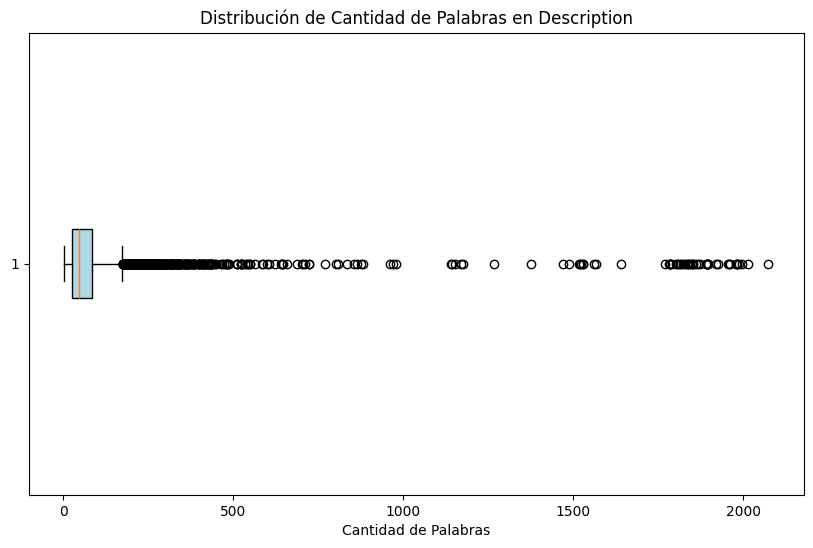

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular el número de palabras en `description`
df_rnp2['description_word_count'] = df_rnp2['description'].apply(lambda x: len(x.split()))

# Crear el boxplot del número de palabras
plt.figure(figsize=(10, 6))
plt.boxplot(df_rnp2['description_word_count'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de Cantidad de Palabras en Description")
plt.xlabel("Cantidad de Palabras")
plt.show()


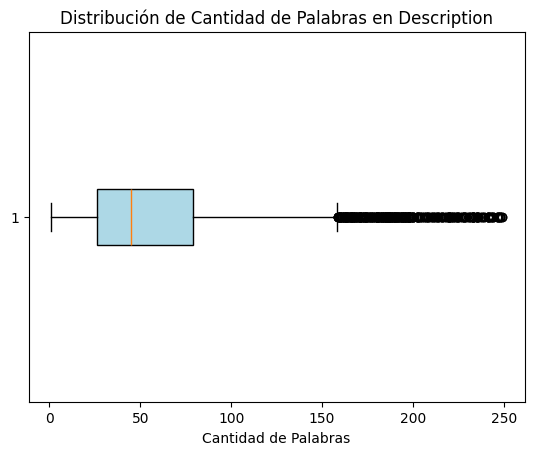

In [ ]:
df_rnp2 = df_rnp2[df_rnp2['description_word_count'].between(0,250 )]
plt.boxplot(df_rnp2['description_word_count'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de Cantidad de Palabras en Description")
plt.xlabel("Cantidad de Palabras")
plt.show()

MAX_LEN selecciono 75 basandome en el boxplot de description. No se selecciona arriba del cuartil 3 porque la RAM no me dejaría.

In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 75
BATCH_SIZE = 16
df = df_rnp
NCLASSES = 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           3  
1  As a developer, I'd like to have a maintenance...  project6           5  
2                            SAM API used by SAM GUI  project1           5  
3  I noticed this when I was testing the unified ...  project5           2  
4  Creating the following stream throws exception...  project6           2  
--------------------------------------------------------------------------------
(7877, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores 1, 2, 3, 5, 8
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,descriptions,labels,tokenizer,max_len):
    self.descriptions = descriptions
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.descriptions)

  def __getitem__(self, item):
    description = str(self.descriptions[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        description,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'description': description,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      descriptions = df.description.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

Agregado porque bert espera labels consecutivos: 0,1,2,3,4  
Luego de predecir debo volver al numero que corresponde cada label

In [ ]:
label_mapping = {1: 0, 2: 1, 3: 2, 5: 3, 8: 4, 10: 5, 13: 6, 20: 7}
df['label'] = df['label'].map(label_mapping)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# basic attributes
print("Batch Size:", train_data_loader.batch_size)
print("Number of Workers:", train_data_loader.num_workers)
print("Dataset:", train_data_loader.dataset)

Batch Size: 16
Number of Workers: 4
Dataset: <__main__.USERSTORIESDataset object at 0x7ae25ac23730>


In [ ]:
print("Number of samples in dataset:", len(train_data_loader.dataset))
print("Sample of dataset item:", train_data_loader.dataset[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Number of samples in dataset: 6301
Sample of dataset item: {'description': 'Steps to reproduce :    1) Open Launch configuration wizard  2) Create a launch configuration for Run -> iOS Application Installer or iTunes Distribution    The provisioning profile is not available though it is already configured on the machine. The same launch configurations on 3.1.2 are displaying provisioning profiles without any errors.    The iOS preferences also does not display the provisioning profiles on 3.2.0', 'input_ids': tensor([  101, 27913,  1106, 23577,   131,   122,   114,  3353, 26738,  9566,
        16678,   123,   114,   140, 15998,   170,  4286,  9566,  1111,  6728,
          118,   135, 18471, 22491,  1130, 19760,  2879,  1137, 12145, 19806,
         1109,  9348,  1158,  6168,  1110,  1136,  1907,  1463,  1122,  1110,
         1640, 14255, 18930,  1113,  1103,  3395,   119,  1109,  1269,  4286,
        25209,  1113,   124,   119,   122,   119,   123,  1132, 15959,  9348,
         1158, 21

####Creación Modelo

cambio self.drop = nn.Dropout(p=0.5)

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.5) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 50% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 5

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Entrenamiento

cambio en taza de aprendizaje a: lr=1e-5

In [ ]:
# ENTRENAMIENTO
EPOCHS = 8
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error

# Mapeo inverso
inverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}

# Modificar la función de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Guardar etiquetas y predicciones
        all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
        all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse

# Modificar la función de evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Guardar etiquetas y predicciones
            all_labels.extend([inverse_label_mapping[label.item()] for label in labels])
            all_preds.extend([inverse_label_mapping[pred.item()] for pred in preds])

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    return correct_predictions.double() / n_examples, np.mean(losses), rmse


In [ ]:
# Entrenamiento
import torch
from google.colab import files
import warnings

# Suprimir todos los warnings
warnings.filterwarnings("ignore")

# Entrenamiento
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    # Entrenamiento y evaluación
    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")

    # Guardar el modelo en el directorio actual
    checkpoint_path = f"epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Modelo guardado en: {checkpoint_path}")


####Conclusión
* Me habían salido métricas muy parecidas que con title, por lo que decido no pasar a validación con test.
* Se tardó mucho más tiempo en entrenar. Aproximadamente 2 horas por epoch. Esto es porque el max_len lo subi de 30 a 75.

##Ensamble a mano de 3 modelos
El plan es crear tres modelos.  
* 1 filtra si sotrypoints es mayor o menor a 8.  
* 1 predice storypoints del 1 al 8.  
* 1 predice storypoints mayores a 8.

###Modelo filtro
filtra si sotrypoints es mayor o menor a 8

In [ ]:
df=pd.read_csv("train.csv")

####Preprocesamiento

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


In [ ]:
df.loc[df['storypoint'] <=8, 'storypoint'] = 0

In [ ]:
df.loc[df['storypoint'] >8, 'storypoint'] = 1

In [ ]:
pd.unique(df['storypoint']).tolist()

[0, 1]

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
0,7656,96.911392
1,244,3.088608


In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap


In [ ]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 16
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
print(df.head())
print('-'*80)
print(df.shape)
print('-'*80)
print("\n".join(wrap(df['description'][500])))

     id                                              title  \
0  5660  Error enabling Appcelerator services during ap...   
1  9014                        Create a maintenance branch   
2  4094  Service Activity Monitoring Backend integrated...   
3   811  fs::enter(rootfs) does not work if 'rootfs' is...   
4  4459   transform processor with script option is broken   

                                         description   project  storypoint  
0  When creating the default app, I encountered t...  project8           0  
1  As a developer, I'd like to have a maintenance...  project6           0  
2                            SAM API used by SAM GUI  project1           0  
3  I noticed this when I was testing the unified ...  project5           0  
4  Creating the following stream throws exception...  project6           0  
--------------------------------------------------------------------------------
(7900, 5)
--------------------------------------------------------------------------

In [ ]:
# Reajustar dataset, sacamos storypoint y agregamos "label" con valores
df['label'] = df['storypoint']
df.drop('storypoint', axis=1, inplace=True)
df.head()

,id,title,description,project,label
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,0
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,0
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,0
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,0
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,0


####Tokenización

Usamos el mismo tokenizador que usa el modelo de bert

documentación de tokenizador que usamos: https://huggingface.co/google-bert/bert-base-cased

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

####Creación del dataset

In [ ]:
# CREACIÓN DATASET

class USERSTORIESDataset(Dataset):

  #max_len a leer
  def __init__(self,titles,labels,tokenizer,max_len):
    self.titles = titles
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        title,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'title': title,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = USERSTORIESDataset(
      titles = df.title.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

creacion de los dataset y de conjunto train y test

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label'])


train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Manejo el desbalance de clases.

In [ ]:
(df['label'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
label,,
0,7656,96.911392
1,244,3.088608


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos para cada clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Actualizar la función de pérdida con los pesos de clase
class_weights = torch.tensor([0.1, 0.9], dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)



####Creación Modelo

In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # El modelo ya pre entrenado.
    self.drop = nn.Dropout(p=0.5) #evitamos el sobreentrenamiento (durante el entrenamiento, apagamos aleatoriamente el 50% de las neuronas)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #768 neuronas de salidas de BERT, n_classes = 2 (positivo/negativo)

  #otro requerimiento de PyTorch: tengo que especificar el orden de las capas neuronales
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


Instanciar el modelo

In [ ]:
model = BERTSentimentClassifier(NCLASSES) #creamos el modelo
model = model.to(device) #device acá es la GPU, con esta linea le decimos que mande el modelo a la GPU

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Entrenamiento

In [ ]:
# ENTRENAMIENTO
EPOCHS = 18
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)


total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import torch.nn as nn

# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()  # Modo entrenamiento
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)  # Predicciones de la clase más probable

        loss = loss_fn(outputs, labels)  # Cálculo de la pérdida
        correct_predictions += torch.sum(preds == labels)  # Predicciones correctas
        losses.append(loss.item())

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Backpropagation y optimización
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)
    return correct_predictions.double() / n_examples, np.mean(losses), rmse


# Iteración evaluación
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Modo evaluación
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calcular RMSE
    rmse = mean_squared_error(all_labels, all_preds, squared=False)
    return correct_predictions.double() / n_examples, np.mean(losses), rmse


In [ ]:
# Entrenamiento
import torch
from google.colab import files
import warnings

# Suprimir todos los warnings
warnings.filterwarnings("ignore")


for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} de {EPOCHS}")
    print("------------------")

    train_acc, train_loss, train_rmse = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    test_acc, test_loss, test_rmse = eval_model(
        model, test_data_loader, loss_fn, device, len(df_test)
    )

    print(f"Entrenamiento: Loss: {train_loss}, Accuracy: {train_acc}, RMSE: {train_rmse}")
    print(f"Validación: Loss: {test_loss}, Accuracy: {test_acc}, RMSE: {test_rmse}")
    print("")
    # Guardar el modelo en el directorio actual
    checkpoint_path = f"epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Modelo guardado en: {checkpoint_path}")

Epoch 1 de 18
------------------
Entrenamiento: Loss: 0.707780809152895, Accuracy: 0.9623417721518988, RMSE: 0.19405727981217624
Validación: Loss: 0.6602338252382146, Accuracy: 0.9689873417721518, RMSE: 0.17610411189931965

Modelo guardado en: epoch_1.pth
Epoch 2 de 18
------------------
Entrenamiento: Loss: 0.6654418168000028, Accuracy: 0.9691455696202531, RMSE: 0.17565429223263188
Validación: Loss: 0.72468790945343, Accuracy: 0.9689873417721518, RMSE: 0.17610411189931965

Modelo guardado en: epoch_2.pth
Epoch 3 de 18
------------------
Entrenamiento: Loss: 0.5291763185037158, Accuracy: 0.9689873417721518, RMSE: 0.17610411189931965
Validación: Loss: 0.955734559220751, Accuracy: 0.9613924050632912, RMSE: 0.19648815469821293

Modelo guardado en: epoch_3.pth
Epoch 4 de 18
------------------
Entrenamiento: Loss: 0.3127246945834854, Accuracy: 0.9781645569620253, RMSE: 0.14776820712851152
Validación: Loss: 1.1025851437048233, Accuracy: 0.9563291139240506, RMSE: 0.20897580260869766

Modelo g

KeyboardInterrupt: 

Detuve el entrenamiento, solo estaba empeorando. Me quedo con epoch 2

In [ ]:
# Cargar los pesos guardados
checkpoint_path = "epoch_2.pth"  # Ruta al archivo descargado
model.load_state_dict(torch.load(checkpoint_path))

model.eval()  # Para evaluación

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

Defino una funion para clasificar un solo title

In [ ]:
def classify_storypoints(text):
    encoding_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}
    return reverse_label_mapping[prediction.item()]


In [ ]:
text = "easy peasy"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 1


In [ ]:
text = "Support docker image labels."
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 1


In [ ]:
text = "Multiline Search: find should jump to string matches when scope is set to open files"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')


Storypoint predicho: 1


In [ ]:
text = "Rabbit Source Should Expose More Container Options"
predicted_storypoint = classify_storypoints(text)
print(f'Storypoint predicho: {predicted_storypoint}')

Storypoint predicho: 1


####Predecir con data test

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8, 5: 10, 6: 13, 7: 20}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})


In [ ]:
unseen_data = pd.DataFrame({
    'id': df_test['id'],
    'description': df_test['description'],
    'project': df_test['project']
})

In [ ]:
unseen_data=pd.read_csv("test.csv")

In [ ]:
predicted_df = predict_storypoints(unseen_data, model, tokenizer, MAX_LEN)

In [ ]:
predicted_df = predicted_df.set_index('id')

In [ ]:
predicted_df

,predicted_storypoints
id,
3433,1
106,1
7182,1
8985,1
2149,1
...,...
9069,1
3100,1
6648,1


In [ ]:
predicted_df.predicted_storypoints.value_counts()

,count
predicted_storypoints,
1,1975


EL modelo aprendió a sólo predecir que son menores a 8. No lo uso. Pruebo filtrar de otra manera.

###Modelo menores a 8


####Carga del modelo
 Carga de modelo 4 de Redes Neuronales Profundas Clasificacion
Cargo modelo guardado anteriormente, que era preciso en predecir numeros del 1 al 8

In [ ]:
!pip install torch
import torch

In [ ]:
model = torch.load('BERTmodel4.pt')

<ipython-input-134-db5b04872eda>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('BERTmodel4.pt')


In [ ]:
import copy
modelmenores = copy.deepcopy(model)

In [ ]:
modelmenores.eval()  # Para evaluación

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

###Modelo mayores a 8 XGB

Voy a entrenar un XGBoost de regresion con un df de sólo storypoints masyores a 8

In [ ]:
df=pd.read_csv("train.csv")

####Preprocesamiento

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
3,1848,23.392405
5,1693,21.430380
1,1629,20.620253
2,1276,16.151899
8,1025,12.974684
4,166,2.101266
13,154,1.949367
10,32,0.405063
20,31,0.392405


Dropeo los storypints menores a 8

In [ ]:
df.loc[df['storypoint'] <9, 'storypoint'] = 1

In [ ]:
story_points_to_drop = [1]
df = df[~df['storypoint'].isin(story_points_to_drop)]

In [ ]:
pd.unique(df['storypoint']).tolist()

[13, 40, 20, 10, 15, 32, 12, 16, 21, 34, 14, 24]

Finalmente los storypoints de nuestro df queda así:

In [ ]:
(df['storypoint'].value_counts(normalize=False)
 .to_frame('Count')
 .assign(Percentage=lambda x: 100 * x['Count'] / x['Count'].sum())
)

,Count,Percentage
storypoint,,
13,154,63.114754
10,32,13.114754
20,31,12.704918
16,7,2.868852
12,6,2.459016
40,5,2.049180
21,3,1.229508
15,2,0.819672
32,1,0.409836


uso el 100% de datos para entrenarlo. Y uso estructura del mejor modelo de xgb que nos habia dado antes.

In [ ]:
X_train_text = df.description.copy()
y_train = df.storypoint.copy()

In [ ]:
X_train_text.tolist()[:7]

['The current build path entry UI doesn\'t retain ordering (see TISTUD-3106) and lists all "contributed" entries with checkboxes. We should move closer to the JDT\'s classpath UI. We need to allow the user to add/remove entries and manage the ordering of the entries. Additionally, the "contributed" entries should just become suggestions for adding - but the user should also be able to manually add an entry for a JSCA/SDOCML file, JS file, or a directory tree (that wasn\'t explicitly "contributed").    We may also want some notion of "required" entries like JS Core (or for Titanium projects the Titanium SDK\'s API and modules paths).',
 'Prereqs  Install Android SDK  Install Android NDK  Update settings in Titanium preferences    Steps:  1. Create an android module project  2. Package the module    Expected results  Module is packaged    Actual results:  NPE in the AntRunner and this following error  (Build 1.0.0.qualifier) [ERROR]  /Users/nle/Library/Application Support/Titanium/mobile

In [ ]:
def clean_text(text):
  return text.strip()

In [ ]:
def tokenizer(text):
    #return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return [w.lower() for w in word_tokenize(text) if w.isalpha()]

In [ ]:
stoplist = stopwords.words("english")

In [ ]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# tokenizo el stoplist con el mismo tokenizar que voy a usar en el corpus
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)

In [ ]:
stoplist_tokenized = list(set(stoplist_tokenized))

In [ ]:
tokenizer(clean_text(X_train_text.iloc[0]))[:100]

['the',
 'current',
 'build',
 'path',
 'entry',
 'ui',
 'does',
 'retain',
 'ordering',
 'see',
 'and',
 'lists',
 'all',
 'contributed',
 'entries',
 'with',
 'checkboxes',
 'we',
 'should',
 'move',
 'closer',
 'to',
 'the',
 'jdt',
 'classpath',
 'ui',
 'we',
 'need',
 'to',
 'allow',
 'the',
 'user',
 'to',
 'entries',
 'and',
 'manage',
 'the',
 'ordering',
 'of',
 'the',
 'entries',
 'additionally',
 'the',
 'contributed',
 'entries',
 'should',
 'just',
 'become',
 'suggestions',
 'for',
 'adding',
 'but',
 'the',
 'user',
 'should',
 'also',
 'be',
 'able',
 'to',
 'manually',
 'add',
 'an',
 'entry',
 'for',
 'a',
 'file',
 'js',
 'file',
 'or',
 'a',
 'directory',
 'tree',
 'that',
 'was',
 'explicitly',
 'contributed',
 'we',
 'may',
 'also',
 'want',
 'some',
 'notion',
 'of',
 'required',
 'entries',
 'like',
 'js',
 'core',
 'or',
 'for',
 'titanium',
 'projects',
 'the',
 'titanium',
 'sdk',
 'api',
 'and',
 'modules',
 'paths']

In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Preprocesamiento de texto
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=17,
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2)
)

# Transformar todo el conjunto de datos
X_train_xgboost = count_vect.fit_transform(df.description)
y_train2 = df.storypoint

# Modelo XGBoost
second_model = xgb.XGBRegressor()

# Hiperparámetros para RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [3, 6, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
}

# Optimización con RandomizedSearchCV
random_search = RandomizedSearchCV(
    second_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_xgboost, y_train2)

# Mejor modelo
best_model = random_search.best_estimator_

# Entrenamiento final
best_model.fit(X_train_xgboost, y_train2)

# Guardar el modelo entrenado
joblib.dump(best_model, 'xgboost_model_v2.joblib')
# Guardar el vectorizador ajustado
joblib.dump(count_vect, 'count_vect_mayores_a_8.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits


['count_vect_mayores_a_8.pkl']

In [ ]:
import copy
modelmayoresa8 = copy.deepcopy(best_model)

###Modelo Filtro

Uso mejor modelo de xgb.

In [ ]:
df=pd.read_csv("train.csv")

In [ ]:
df = df.drop(df[df['storypoint'].isin([32,34,14,24])].index)

In [ ]:
#Para poder unir los predicted con reales
df.set_index('id', inplace=True)

In [ ]:
X_train_text2 = df.description.copy()
y_train2 = df.storypoint.copy()

In [ ]:
X_train_text2.tolist()[:7]

['When creating the default app, I encountered the error during enabling of appcelerator services. Please, see the attachment.    Note: I noticed Environment choice(screenshot), which is not working.',
 "As a developer, I'd like to have a maintenance branch so that I can commit MINOR release _(ex: 1.0.2)_ code changes instead of committing to MASTER.",
 'SAM API used by SAM GUI',
 'I noticed this when I was testing the unified containerizer with the bind mount backend and no volumes.    The current implementation of fs::enter will put the old root under /tmp/._old_root_.XXXXXX in the new rootfs. It assumes that /tmp is writable in the new rootfs, but this might not be true, especially if the bind mount backend is used.    To solve the problem, what we can do is to mount tmpfs to /tmp in the new rootfs and umount it after pivot_root.',
 'Creating the following stream throws exception:    stream create s1 --definition "http | transform --script=transform.groovy | log"  Command failed org

In [ ]:
tokenizer(clean_text(X_train_text2.iloc[0]))[:100]

['when',
 'creating',
 'the',
 'default',
 'app',
 'i',
 'encountered',
 'the',
 'error',
 'during',
 'enabling',
 'of',
 'appcelerator',
 'services',
 'please',
 'see',
 'the',
 'attachment',
 'note',
 'i',
 'noticed',
 'environment',
 'choice',
 'screenshot',
 'which',
 'is',
 'not',
 'working']

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

# Primero, el CountVectorizer y la función de limpieza de texto.
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=17,
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),  # Usamos unigramas y bigramas
)

# Transformamos los datos de texto en características numéricas
X_train_xgboost = count_vect.fit_transform(X_train_text2)

# Definir el modelo XGBoost
second_model = xgb.XGBRegressor()

# Evaluar el modelo con validación cruzada usando RMSE
scores_cv_xgboost = cross_val_score(second_model, X_train_xgboost, y_train2, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE = ", round(scores_cv_xgboost.mean(), 4), " (sd =", round(scores_cv_xgboost.std(), 4), ")")

# **Optimización de hiperparámetros con RandomizedSearchCV**

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Probar tasas de aprendizaje más bajas
    'n_estimators': [100, 200, 400, 600],  # Experimentar con diferentes números de estimadores
    'max_depth': [3, 6, 8, 10],  # Profundidad de los árboles
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporción de muestras a usar
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporción de características a usar por árbol
    'min_child_weight': [1, 3, 5, 10],  # Peso mínimo de un nodo hijo
    'gamma': [0, 0.1, 0.2, 0.5],  # Gamma para la regularización
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}

# Usamos RandomizedSearchCV para la búsqueda de hiperparámetros

random_search = RandomizedSearchCV(
    second_model,  # El modelo
    param_distributions=param_dist,  # Distribuciones de los hiperparámetros
    n_iter=10,  # ajustar según el caso
    cv=5,  # Validación cruzada
    scoring='neg_root_mean_squared_error',  # Métrica RMSE negativa para regresión
    verbose=2,  # Proveer más detalles sobre el progreso
    n_jobs=-1,  # Usamos todos los núcleos disponibles para acelerar la búsqueda
    random_state=42,  # Asegura la reproducibilidad de los resultados
)

# Ajustamos el modelo con RandomizedSearchCV
random_search.fit(X_train_xgboost, y_train2)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search.best_params_)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Evaluar el modelo optimizado con validación cruzada usando RMSE
scores_cv_best_model = cross_val_score(best_model, X_train_xgboost, y_train2, cv=6, scoring='neg_root_mean_squared_error')
print("NEG RMSE (modelo optimizado) = ", round(scores_cv_best_model.mean(), 4), " (sd =", round(scores_cv_best_model.std(), 4), ")")

# Finalmente, podemos obtener otras métricas para evaluar el modelo

# Predicciones en el conjunto de entrenamiento para calcular otras métricas
y_pred = best_model.predict(X_train_xgboost)

# Calcular R2
r2 = r2_score(y_train2, y_pred)
print(f"R2 Score: {r2:.4f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_train2, y_pred)
print(f"MAE: {mae:.4f}")

# Calcular RMSE
rmse = mean_squared_error(y_train2, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NEG RMSE =  -2.6947  (sd = 0.1457 )
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros encontrados:  {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
NEG RMSE (modelo optimizado) =  -2.671  (sd = 0.1333 )
R2 Score: 0.7439
MAE: 1.0973
RMSE: 1.5091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
model_xgb_filtro=copy.deepcopy(best_model)

In [ ]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model.fit(X_train_xgboost, y_train2)

# Guardamos el modelo entrenado
joblib.dump(best_model, 'xgboost_model_v2.joblib')
# Guardar el vectorizador ajustado
joblib.dump(count_vect, 'count_vect_filtro.pkl')
# Cargamos el conjunto de datos de prueba
df_test = pd.read_csv("test.csv")
df_test.set_index('id', inplace=True)
X_test_text = df_test.description

# Transformamos los datos de prueba con el mismo CountVectorizer que usamos en el entrenamiento
X_test_xgboost = count_vect.transform(X_test_text)

# Cargamos el modelo guardado
loaded_model = joblib.load('xgboost_model_v2.joblib')

# Hacemos predicciones en el conjunto de datos de prueba
y_pred = loaded_model.predict(X_test_xgboost).round().astype(int)

# Creamos un DataFrame con las predicciones
results_df = pd.DataFrame({'Predicted': y_pred})
results_df.index = X_test_text.index

# Mostramos el DataFrame
results_df

,Predicted
id,
3433,5
106,4
7182,2
8985,2
2149,2
...,...
9069,4
3100,5
6648,3


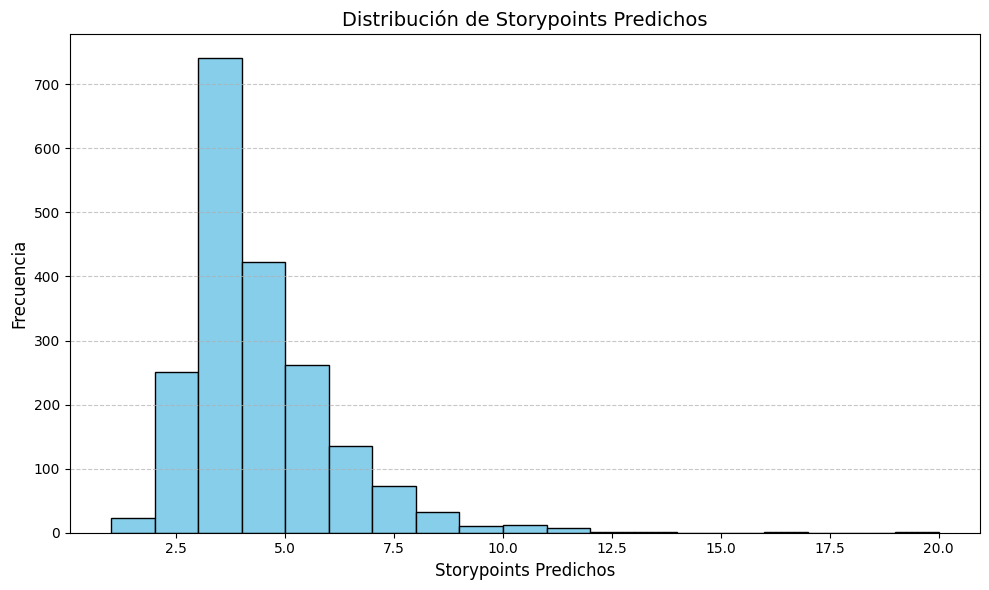

In [ ]:
import matplotlib.pyplot as plt

# Histograma de la columna Predicted
plt.figure(figsize=(10, 6))
plt.hist(results_df['Predicted'], bins=range(results_df['Predicted'].min(), results_df['Predicted'].max() + 1), color='skyblue', edgecolor='black')

plt.xlabel('Storypoints Predichos', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Storypoints Predichos', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


###Uniendo los 3 modelos

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xgboost as xgb
from transformers import BertTokenizer
import joblib

# Cargar los tokenizadores y modelos
bert_tokenizer_menores_a_8 = BertTokenizer.from_pretrained('bert_tokenizer_menores_a_8')
count_vect_binary = joblib.load('count_vect_mayores_a_8.pkl')
count_vect_1_10 = joblib.load('count_vect_filtro.pkl')

# Cargar los modelos entrenados
model_xgb_filtro =model_xgb_filtro
modelmenores = modelmenores
modelmayoresa8 = modelmayoresa8


In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})

In [ ]:
def hierarchical_prediction(df, model_binary, model_1_10, model_10_30, count_vect_binary, count_vect_1_10, count_vect_10_30, tokenizer_menores_a_8):
    map_1_10 = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}
    predictions = []

    for _, row in df.iterrows():
        # Paso 1: Predicción binaria usando "description"
        input_text_desc = clean_text(row['description'])
        binary_features = count_vect_binary.transform([input_text_desc])
        binary_pred = model_binary.predict(binary_features)

        # Initialize story_point before the conditional blocks
        story_point = None

        if binary_pred < 9:  # Modelos menores a 9, usar "title"
            input_text_title = clean_text(row['title'])

            # Realizar predicción con el modelo de menores a 8 (usando la función predict_storypoints)
            storypoint_df = predict_storypoints(pd.DataFrame([row]), model_1_10, tokenizer_menores_a_8, 30)
            story_point = storypoint_df['predicted_storypoints'][0] # Assign to story_point

        else:  # Modelos mayores o iguales a 9, usar "description"
            features_10_30 = count_vect_10_30.transform([input_text_desc])
            raw_pred = model_10_30.predict(features_10_30)
            story_point = int(raw_pred[0]) # Assign to story_point

        predictions.append({"id": row["id"], "predicted_storypoint": story_point})

    return pd.DataFrame(predictions)

In [ ]:
# Cargar los datos no vistos
df_new = pd.read_csv("test.csv")

# Realizar predicciones
result_df = hierarchical_prediction(
    df=df_new,
    model_binary=model_xgb_filtro,
    model_1_10=modelmenores,
    model_10_30=modelmayoresa8,
    count_vect_binary=count_vect_1_10,
    count_vect_1_10=bert_tokenizer_menores_a_8,
    count_vect_10_30=count_vect_binary,
    tokenizer_menores_a_8=bert_tokenizer_menores_a_8
)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
result_df = result_df.set_index('id')

In [ ]:
result_df

,predicted_storypoint
id,
3433,5
106,3
7182,3
8985,1
2149,1
...,...
9069,3
3100,1
6648,2


In [ ]:
result_df.predicted_storypoint.value_counts()

,count
predicted_storypoint,
3,724
5,435
1,423
2,294
8,71
14,5
15,5
13,3
20,3


En kaggle: 3.22

###Usando 2 modelos

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xgboost as xgb
from transformers import BertTokenizer
import joblib

# Cargar los tokenizadores y modelos
bert_tokenizer_menores_a_8 = BertTokenizer.from_pretrained('bert_tokenizer_menores_a_8')
count_vect_binary = joblib.load('count_vect_mayores_a_8.pkl')
count_vect_1_10 = joblib.load('count_vect_filtro.pkl')

# Cargar los modelos entrenados
model_xgb_filtro =model_xgb_filtro
modelmenores = modelmenores
modelmayoresa8 = modelmayoresa8

In [ ]:
def predict_storypoints(df, model, tokenizer, max_len):
    model.eval()
    predictions = []
    ids = []
    reverse_label_mapping = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}

    with torch.no_grad():
        for _, row in df.iterrows():
            encoding = tokenizer.encode_plus(
                row['description'],
                max_length=max_len,
                truncation=True,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)
            storypoint = reverse_label_mapping[prediction.item()]
            predictions.append(storypoint)
            ids.append(row['id'])

    return pd.DataFrame({'id': ids, 'predicted_storypoints': predictions})

In [ ]:
def hierarchical_prediction(df, model_binary, model_1_10, model_10_30, count_vect_binary, count_vect_1_10, count_vect_10_30, tokenizer_menores_a_8):
    map_1_10 = {0: 1, 1: 2, 2: 3, 3: 5, 4: 8}
    predictions = []

    for _, row in df.iterrows():
        # Paso 1: Predicción binaria usando "description"
        input_text_desc = clean_text(row['description'])
        binary_features = count_vect_binary.transform([input_text_desc])
        binary_pred = model_binary.predict(binary_features)
        story_point = None

        if binary_pred < 9:  # Modelos menores a 9, usar "title"
            input_text_title = clean_text(row['title'])

            storypoint_df = predict_storypoints(pd.DataFrame([row]), model_1_10, tokenizer_menores_a_8, 30)
            story_point = storypoint_df['predicted_storypoints'][0]

        else:
            features_10_30 = count_vect_10_30.transform([input_text_desc])
            raw_pred = model_10_30.predict(features_10_30)
            story_point = int(raw_pred[0])

        predictions.append({"id": row["id"], "predicted_storypoint": story_point})

    return pd.DataFrame(predictions)

In [ ]:
# Cargar los datos no vistos
df_new = pd.read_csv("test.csv")

# Realizar predicciones
result_df = hierarchical_prediction(
    df=df_new,
    model_binary=model_xgb_filtro,
    model_1_10=modelmenores,
    model_10_30=model_xgb_filtro,
    count_vect_binary=count_vect_1_10,
    count_vect_1_10=bert_tokenizer_menores_a_8,
    count_vect_10_30=count_vect_1_10,
    tokenizer_menores_a_8=bert_tokenizer_menores_a_8
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
result_df = result_df.set_index('id')

In [ ]:
result_df

,predicted_storypoint
id,
3433,5
106,3
7182,3
8985,1
2149,1
...,...
9069,3
3100,1
6648,2


In [ ]:
result_df.predicted_storypoint.value_counts()

,count
predicted_storypoint,
3,724
5,435
1,423
2,294
8,71
10,13
9,8
11,3
12,2


En kaggle: 3.13

###Conclusión:
Al usar 3 modelos entrenados para tareas especificas:
* Predecir menores o mayores a 8. Dado este resultado se usa uno de los siguientes dos.
* Predecir entre 1 y 8
* Predecir mayores a 8

Los resultados no fueron mejores que un modelo por si sólo.

##Ensambles Stacking

###Ensamble Stacking 1

Pruebo el Ensamble con los modelos bases de XGBoost, Random Forest y Red Neuronal. Usando los mejores modelos

In [ ]:
!pip install scikeras[tensorflow]
from scikeras.wrappers import KerasRegressor

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('train.csv')
df.set_index('id', inplace=True)

df = df.drop(df[df['storypoint'].isin([32,34,14,24])].index)

df['description'] = df['description'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)

#Seleccion variables regresoras y objetivo
X = df.description
y = df.storypoint

#traine y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


#modelos base
xgb = joblib.load('xgboost_model_v3.joblib') #joblib del mejor modelo de xgboost que es el xgboost v2
rf = joblib.load('RandomForest_v2_mejorRF.joblib') #joblib del mejor modelo de random forest, que es el random forest v2
rn = KerasRegressor(build_fn=joblib.load('rn_v6_mejorRN.joblib')) #joblib del mejor modelo de Red Neuronal, que es el modelo 6

#meta-modelo
meta_model = LinearRegression()

#se hace el ensamble
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('rn', rn)
    ],
    final_estimator=meta_model,
    cv=5  #validación cruzada
)


count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=20,
                             stop_words=stoplist)

X_train_stk_transform = count_vect.fit_transform(X_train)
X_test_stk_transform = count_vect.transform(X_test)

#Entrenmiento
stacking_model.fit(X_train_stk_transform, y_train)

#test
y_pred = stacking_model.predict(X_test_stk_transform)

rmse_stacking = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse_stacking:.4f}")

RMSE = root_mean_squared_error(y_pred, y_test)
print("RMSE:", RMSE)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup construct

198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - RootMeanSquaredError: 3.0977 - loss: 9.6050 - mae: 2.2348


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - RootMeanSquaredError: 3.0624 - loss: 9.4075 - mae: 2.1970
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - RootMeanSquaredError: 3.0144 - loss: 9.0937 - mae: 2.2173
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - RootMeanSquaredError: 3.1198 - loss: 9.7928 - mae: 2.2375
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - RootMeanSquaredError: 3.1617 - loss: 10.0267 - mae: 2.2143
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - RootMeanSquaredError: 3.1716 - loss: 10.0827 - mae: 2.2638
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 2.4637
RMSE: 2.4637355669850054
R2: 0.24978040754655018
MSE: 6.069992944026925


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
joblib.dump(stacking_model, 'Stacking_v1.joblib')

['Stacking_v1.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_stacking_desc = df_test.title
X_test_stacking = count_vect.transform(X_stacking_desc)

<ipython-input-74-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
# Load the saved model
clf = joblib.load('Stacking_v1.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_stacking).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_stacking_desc.index

results_onlyP

results = pd.DataFrame({'id': X_stacking_desc.index, 'storypoint': y_pred})
results.to_csv('Stacking_v1.csv', index=False)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
results_onlyP.value_counts()

,count
Predicted,
3,1253
4,316
2,231
5,130
6,39
7,5
8,1


In [ ]:
results_onlyP

,Predicted
id,
3433,4
106,3
7182,3
8985,3
2149,3
...,...
9069,3
3100,2
6648,2


###Ensamble Stacking 2

Usamos como modelos base tres modelos sencillos de xgboost, random forest y red neuronal

In [ ]:
!pip install scikeras[tensorflow]
from scikeras.wrappers import KerasRegressor

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('train.csv')
df.set_index('id', inplace=True)

df = df.drop(df[df['storypoint'].isin([32,34,14,24])].index)

#Seleccion variables regresoras y objetivo
X = df.description
y = df.storypoint

#traine y test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=12)


count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=20,
                             stop_words=stoplist)

X_train_stk_2_transform = count_vect.fit_transform(X_train_2)
X_test_stk_2_transform = count_vect.transform(X_test_2)

valores_salida = 1
valores_entrada = X_train_stk_2_transform.shape[1]

simple_rn = keras.Sequential([
    keras.layers.Dense(valores_salida,input_shape=(valores_entrada,))])

simple_rn.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
               loss='mean_squared_error',
               metrics=['mae', 'RootMeanSquaredError'])

#modelos base
lineal = LinearRegression()
rf = RandomForestRegressor()
rn = KerasRegressor(simple_rn)

#meta-modelo
meta_model = XGBRegressor()

#se hace el ensamble
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('lineal', lineal),
        ('rn', rn)
    ],
    final_estimator=meta_model,
    cv=5  #validación cruzada
)


#Entrenmiento
stacking_model.fit(X_train_stk_2_transform, y_train_2)

#test
y_pred = stacking_model.predict(X_test_stk_2_transform)

rmse_stacking_2 = mean_squared_error(y_test_2, y_pred, squared=False)
print(f"RMSE: {rmse_stacking_2:.4f}")

RMSE = root_mean_squared_error(y_pred, y_test_2)
print("RMSE:", RMSE)

r2 = r2_score(y_test_2, y_pred)
print("R2:", r2)

mse = mean_squared_error(y_test_2, y_pred)
print("MSE:", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-609-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-609-bdf680bfddf7>:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an X

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 31021646.0000 - loss: 3182340717150208.0000 - mae: 2864193.5000
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 6099.3599 - loss: 150516368.0000 - mae: 500.3113
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 219738.9688 - loss: 1070472560640.0000 - mae: 9665.1523
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 726.2611 - loss: 1754058.8750 - mae: 65.6550
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 92362.0547 - loss: 83178455040.0000 - mae: 5483.5659
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 2213444.0000 - loss: 32193040613376.0000 - mae: 169881.1406
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 2.8291
RMSE: 2.829101703139251
R2: 0.010769

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
joblib.dump(stacking_model, 'Stacking_v2.joblib')

['Stacking_v1.joblib']

In [ ]:
#Cargo el test para realizar predicción a hacer submit en Kaggle (solamente se hace eso)
df_test=pd.read_csv("test.csv")
#Para poder unir los predicted con reales
df_test.set_index('id', inplace=True)

X_stacking_desc_2 = df_test.description
X_test_stacking_2 = count_vect.transform(X_stacking_desc_2)

In [ ]:
# Load the saved model
clf = joblib.load('Stacking_v2.joblib')

#round().astype(int) me redondea la prediccion, porque sin eso me da con un numero decimal
y_pred = clf.predict(X_test_stacking_2).round().astype(int)


results_onlyP = pd.DataFrame({'Predicted': y_pred})

results_onlyP.index = X_stacking_desc_2.index

results_onlyP

results = pd.DataFrame({'id': X_stacking_desc_2.index, 'storypoint': y_pred})
results.to_csv('Stacking_v1.csv', index=False)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
results_onlyP.value_counts()

,count
Predicted,
3,785
4,355
2,311
5,291
6,160
7,53
8,16
1,3
9,1


In [ ]:
results_onlyP

,Predicted
id,
3433,5
106,3
7182,2
8985,2
2149,2
...,...
9069,4
3100,3
6648,2


###Conclusion
Luego de realizar varias combinaciones de modelos bases y meta modelos, obtuvimos que el mejor modelo de Stacking es aquel que usamos como modelos base al mejor modelo de XGBoost (XGBoost_v7), al mejor modelo de Random Forest (Random_Forest_v2), y al mejor modelo de Redes Neuronales (Red_Neuronal_V6), y como meta modelo, una Regresion lineal, en base a las metricas obtenidas.

#Conclusión Final
Luego de probar con distintas técnicas, muchos modelos distintos, con preprocesamientos usando múltples limpiezas el mejor modelo fue el XGBoost versión 7.